# Setup

In [1]:
# Imports

import itertools
import pickle
import random
import shutil
import warnings
from pathlib import Path

import logomaker
import matplotlib.patheffects as PathEffects
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import polars as pl  # ver=0.20, needs `pyarrow` and `xlsx2csv` packages
import seaborn as sns
import umap
from Bio import motifs
from Bio.Seq import Seq
from matplotlib.lines import Line2D
from matplotlib.transforms import ScaledTranslation
from matplotlib_venn import venn2
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from natsort import natsorted
from scipy.spatial import ConvexHull
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics.pairwise import cosine_similarity
from tqdm.contrib import tzip
from tqdm.notebook import tqdm  # needs `ipywidgets` package

**Remember to review all paths in the Config section below.**

In [6]:
# Config

# Main directories

project_dir = Path("/data/teamgdansk/apalkowski/carmen-analysis")

data_dir = project_dir.joinpath("data")
figures_dir = project_dir.joinpath("figures")
temp_dir = project_dir.joinpath("temp")

data_pub_dir = data_dir.joinpath("to-be-published")

data_subs_dir = data_dir.joinpath("subsidiary-files")

figures_gen_dir = figures_dir.joinpath("script-generated")
figures_main_dir = figures_gen_dir.joinpath("main-panels")
figures_supp_dir = figures_gen_dir.joinpath("supplementary")

# Core source files

# Elements of the CARMEN database (might exist outside of this project directory)
# db_main_file = "/data/teamgdansk/apalkowski/ashwins-database-development/data/final-db/neoantigen-db-main.tsv"
db_main_file = data_dir.joinpath("carmen-main.parquet")

# Haplotype frequencies from NMDP Registry Haplotype Frequencies database
freqs_dir = data_dir.joinpath("nmdp-hla-frequencies")
# freqs_pop_desc_file = f"{data_dir}/{freqs_dir}/populations-description.csv"
freqs_pop_desc_file = freqs_dir.joinpath("populations-description.csv")
freqs_pop_desc_col_pop_code = "Population_code"  # column name
freqs_pop_desc_col_desc = "Description"  # column name
freqs_pop_desc_col_a_b_drb1 = "A_B_DRB1_count"  # column name
freqs_pop_desc_col_c = "C_count"  # column name
freqs_pop_codes = pl.read_csv(freqs_pop_desc_file)[
    freqs_pop_desc_col_pop_code
].to_list()
# The following files are available from the database website (https://frequency.nmdp.org)
# freqs_a_org_file = f"{data_dir}/{freqs_dir}/A.xlsx"
# freqs_b_org_file = f"{data_dir}/{freqs_dir}/B.xlsx"
# freqs_c_org_file = f"{data_dir}/{freqs_dir}/C.xlsx"
# freqs_abc_org_file = f"{data_dir}/{freqs_dir}/A~C~B.xlsx"
freqs_a_org_file = freqs_dir.joinpath("A.xlsx")
freqs_b_org_file = freqs_dir.joinpath("B.xlsx")
freqs_c_org_file = freqs_dir.joinpath("C.xlsx")
freqs_abc_org_file = freqs_dir.joinpath("A~C~B.xlsx")
freqs_col_a = "A"  # column name
freqs_col_b = "B"  # column name
freqs_col_c = "C"  # column name
freqs_org_cols_freqs = [f"{c}_freq" for c in freqs_pop_codes]  # column names

# MHC Motif Atlas peptides, available from the project website (http://mhcmotifatlas.org)
# motif_atlas_peps_src_file = f"{data_dir}/data_classI_all_peptides.txt"
motif_atlas_peps_src_file = data_dir.joinpath("data_classI_all_peptides.txt")
motif_atlas_peps_col_allele = "Allele"  # column name
motif_atlas_peps_col_peptide = "Peptide"  # column name

# Files produced outside of this notebook

# main_samples_file = f"{data_dir}/main-output-table-1.tsv"
# main_samples_file_2 = f"{data_dir}/main-output-table-2.tsv"
main_samples_file = data_dir.joinpath("main-output-table-1.tsv")
main_samples_file_2 = data_dir.joinpath("main-output-table-2.tsv")
main_samples_col_sample_name = "Sample"  # column name
main_samples_col_peptides = "Peptides"  # column name
main_samples_col_binding_alleles = "Binding_alleles"  # column name
main_samples_col_umap_x = "x"  # column name
main_samples_col_umap_y = "y"  # column name
main_samples_col_label = "label"  # column name
main_samples_list_sep = ","

# main_motif_atlas_emb_file = f"{data_dir}/main-embeddings_MHCMotifA_pssms.tsv"
main_motif_atlas_emb_file = data_dir.joinpath("main-embeddings_MHCMotifA_pssms.tsv")
main_motif_atlas_emb_col_x = "0"  # column name
main_motif_atlas_emb_col_y = "1"  # column name

# ml_roc_curve_1_1_hla_file = data_dir.joinpath("1_1_HLA_coordinates.csv")
# ml_roc_curve_1_1_no_hla_file = data_dir.joinpath("1_1_no_HLA_coordinates.csv")
# ml_roc_curve_1_5_hla_file = data_dir.joinpath("1_5_HLA_coordinates.csv")
# ml_roc_curve_1_5_no_hla_file = data_dir.joinpath("1_5_no_HLA_coordinates.csv")
ml_roc_curve_1_1_hla_file = data_dir.joinpath("1_1_balanced_HLA_coordinates.csv")
ml_roc_curve_1_1_no_hla_file = data_dir.joinpath("1_1_balanced_no_HLA_coordinates.csv")
ml_roc_curve_1_5_hla_file = data_dir.joinpath("1_5_balanced_HLA_coordinates.csv")
ml_roc_curve_1_5_no_hla_file = data_dir.joinpath("1_5_balanced_no_HLA_coordinates.csv")
ml_roc_curve_col_x = "x"  # column name
ml_roc_curve_col_y = "y"  # column name

# External database files
ext_data_files = [
    freqs_a_org_file,
    freqs_b_org_file,
    freqs_c_org_file,
    freqs_abc_org_file,
    motif_atlas_peps_src_file,
]

# Generated data files

# Files to be published

samples_pub_file = data_pub_dir.joinpath(
    "carmen-peptide-clusters-characteristics.parquet"
)
samples_pub_col_id = "ID"  # column name

samples_pub_pssms_file = data_pub_dir.joinpath("carmen-peptide-clusters-pssms.json")

# Subsidiary files

# Summarized characteristics of samples
# samples_main_file = f"{data_subs_dir}/samples-main.csv"
# samples_supp_file = f"{data_subs_dir}/samples-supp.csv"
samples_main_file = data_subs_dir.joinpath("samples-main.csv")
samples_supp_file = data_subs_dir.joinpath("samples-supp.csv")
samples_col_sample_name = "Sample_name"  # column name
samples_col_peptides = "Peptides"  # column name
samples_col_binding_alleles = "Binding_alleles"  # column name
samples_col_umap_x = "UMAP_x"  # column name
samples_col_umap_y = "UMAP_y"  # column name
samples_col_label = "Label"  # column name
samples_col_peptides_9 = "Peptides_9"  # column name
samples_col_binding_alleles_clean = "Binding_alleles_clean"  # column name
samples_cols_freqs_a = [f"Freq_{c}_A" for c in freqs_pop_codes]  # column names
samples_cols_freqs_b = [f"Freq_{c}_B" for c in freqs_pop_codes]  # column names
samples_cols_freqs_c = [f"Freq_{c}_C" for c in freqs_pop_codes]  # column names
samples_cols_freqs_abc_any = [
    f"Freq_{c}_ABC_any" for c in freqs_pop_codes
]  # column names
samples_cols_freqs_abc_all = [
    f"Freq_{c}_ABC_all" for c in freqs_pop_codes
]  # column names
samples_list_sep = ";"
samples_list_cols = [
    samples_col_peptides,
    samples_col_binding_alleles,
    samples_col_peptides_9,
    samples_col_binding_alleles_clean,
]

# UMAP model for the supplementary dataset
# umap_reducer_supp_file = f"{data_subs_dir}/umap-reducer-supp.pkl"
umap_reducer_supp_file = data_subs_dir.joinpath("umap-reducer-supp.pickle")

# Modified populations haplotype frequencies files
# freqs_a_file = f"{data_subs_dir}/pop-freqs-a.csv"
# freqs_b_file = f"{data_subs_dir}/pop-freqs-b.csv"
# freqs_c_file = f"{data_subs_dir}/pop-freqs-c.csv"
# freqs_abc_file = f"{data_subs_dir}/pop-freqs-abc.csv"
freqs_a_file = data_subs_dir.joinpath("pop-freqs-a.csv")
freqs_b_file = data_subs_dir.joinpath("pop-freqs-b.csv")
freqs_c_file = data_subs_dir.joinpath("pop-freqs-c.csv")
freqs_abc_file = data_subs_dir.joinpath("pop-freqs-abc.csv")
freqs_cols_freqs = [f"Freq_{c}" for c in freqs_pop_codes]  # column names

# Modified MHC Motif Atlas peptides
# motif_atlas_peps_file = f"{data_subs_dir}/motif-atlas-peptides.csv"
# supp_motif_atlas_emb_file = f"{data_subs_dir}/motif-atlas-supp-umap-emb.csv"
motif_atlas_peps_file = data_subs_dir.joinpath("motif-atlas-peptides.csv")
supp_motif_atlas_emb_file = data_subs_dir.joinpath("motif-atlas-supp-umap-emb.csv")
supp_motif_atlas_emb_col_allele = "Allele"  # column name
supp_motif_atlas_emb_col_x = "UMAP_x"  # column name
supp_motif_atlas_emb_col_y = "UMAP_y"  # column name


# Amino acids combinations in peptides
# aa_combinations_file = lambda n_pos: f"{data_subs_dir}/aa-combinations-9aa-{n_pos}.csv"
def aa_combinations_file(n_pos):
    return data_subs_dir.joinpath(f"aa-combinations-9aa-{n_pos}.csv")


aa_combinations_col_pos = "Positions"  # column name
aa_combinations_col_aa = "Amino_acids"  # column name
aa_combinations_col_pep = "Peptides"  # column name
aa_combinations_list_sep = ";"

# Other

peptide_len = 9

AMINO_ACIDS = [
    "A",
    "R",
    "N",
    "D",
    "C",
    "Q",
    "E",
    "G",
    "H",
    "I",
    "L",
    "K",
    "M",
    "F",
    "P",
    "S",
    "T",
    "W",
    "Y",
    "V",
]

# Matplotlib config
plt.rcdefaults()

main_font_size = 7  # Minimum text size: 5 pt.
label_font_size = 10

max_fig_width_double_col = 180  # mm (Nature standards)
max_fig_width_single_col = 89  # mm
# Figures can also be 120 mm in width where necessary.
# Page height is 279 mm. Content size is about 250/245/243 mm?
max_fig_height = 210  # mm
max_max_fig_height = 243  # mm

default_point_size = 15

axis_color = "0.15"

label_kwargs = dict(
    ha="right", va="center", fontsize=label_font_size, weight="bold", color="black"
)

plt.rcParams["text.color"] = axis_color
plt.rcParams["axes.labelcolor"] = axis_color
plt.rcParams["xtick.color"] = axis_color
plt.rcParams["ytick.color"] = axis_color
plt.rcParams["axes.edgecolor"] = axis_color

plt.rcParams["font.size"] = main_font_size
plt.rcParams["axes.labelsize"] = main_font_size
plt.rcParams["axes.titlesize"] = main_font_size
plt.rcParams["xtick.labelsize"] = main_font_size
plt.rcParams["ytick.labelsize"] = main_font_size
plt.rcParams["legend.fontsize"] = main_font_size
plt.rcParams["figure.labelsize"] = main_font_size
plt.rcParams["figure.titlesize"] = main_font_size

plt.rcParams["axes.spines.top"] = False
plt.rcParams["axes.spines.right"] = False

plt.rcParams["savefig.transparent"] = True

# Not sure about these ones, need to test
plt.rcParams["pdf.fonttype"] = 42
plt.rcParams["ps.fonttype"] = 42
plt.rcParams["svg.fonttype"] = "none"

# This is useful but may cause problems with Seaborn package
# plt.rcParams["figure.constrained_layout.use"] = True

# Setting random seed
random_seed = 42

random.seed(random_seed)
np.random.seed(random_seed)

In [41]:
db_main = pl.read_parquet(db_main_file)

In [42]:
db_main

Study_id,Sample_name,Peptide,Peptide_type,Spectral_count,Assigned_modifications,Haplotype,Netmhcpan_binder
str,str,str,str,i64,str,str,str
"""MSV000080527-84172-84442""","""sample_A0101""","""AADIFYSRY""","""canonical""",12,null,"""A*01:01""","""Y"""
"""MSV000080527-84172-84442""","""sample_A0101""","""AADLNLVLY""","""canonical""",14,null,"""A*01:01""","""Y"""
"""MSV000080527-84172-84442""","""sample_A0101""","""AADPNAAWAAY""","""canonical""",1,null,"""A*01:01""","""Y"""
"""MSV000080527-84172-84442""","""sample_A0101""","""AADPNAAWAAYY""","""canonical""",7,null,"""A*01:01""","""Y"""
"""MSV000080527-84172-84442""","""sample_A0101""","""AAEDIINYTEPKLGY""","""canonical""",1,null,"""A*01:01""","""Y"""
…,…,…,…,…,…,…,…
"""PXD036856""","""sample_3704_ML_7_03""","""YVTDVLYRV""","""canonical""",1,null,"""A*02:01,B*51:01,C*02:02,C*15:0…","""Y,Y,Y,Y"""
"""PXD036856""","""sample_3704_ML_7_03""","""YVTTSTRTY""","""canonical""",4,null,"""A*02:01,B*51:01,C*02:02,C*15:0…","""N,N,Y,N"""
"""PXD036856""","""sample_3704_ML_7_03""","""YVVPFVAKV""","""canonical""",2,null,"""A*02:01,B*51:01,C*02:02,C*15:0…","""Y,Y,Y,Y"""


In [44]:
asd=db_main.group_by("Peptide").agg("Haplotype")
asd

Peptide,Haplotype
str,list[str]
"""AVRDALKTEFK""","[""A*03:01"", null, … ""A*02:01,A*11:01,B*35:01,B*51:01,C*04:01,C*14:02""]"
"""QHHHLPQHL""","[""B*15:10"", ""B*38:01"", … null]"
"""GPLCKKLSL""",[null]
"""SPNDYNKLVL""","[""A*02:01,A*03:01,B*07:02"", ""A*01:01:01,A*24:02:01,B*07:02:01,B*08:01:01,C*07:01:01,C*07:02:01"", … ""A*02:01,B*07:02,C*07:02""]"
"""HEVFVELNEL""","[""A*02:01,A*03:01,B*40:02,B*47,C*03:04,C*06:02"", ""A*02:01,A*03:01,B*40:02,B*47,C*03:04,C*06:02""]"
…,…
"""HPVPQPLQ""",[null]
"""APLLMLGLR""","[""A*03:01,A*68:02,B*07:02,B*14:02,C*07:02,C*08:02""]"
"""TVLGIEAVRKA""","[""A*02:06,A*24:02,B*07:02,B*55:01,C*01:02,C*07:02""]"


In [45]:
asd.with_columns(pl.col("Haplotype").list.join(","))

Peptide,Haplotype
str,str
"""AVRDALKTEFK""","""A*03:01,A*03:01:01,B*35:01,C*0…"
"""QHHHLPQHL""","""B*15:10,B*38:01,B*38:02,A*01:0…"
"""GPLCKKLSL""",""""""
"""SPNDYNKLVL""","""A*02:01,A*03:01,B*07:02,A*01:0…"
"""HEVFVELNEL""","""A*02:01,A*03:01,B*40:02,B*47,C…"
…,…
"""HPVPQPLQ""",""""""
"""APLLMLGLR""","""A*03:01,A*68:02,B*07:02,B*14:0…"
"""TVLGIEAVRKA""","""A*02:06,A*24:02,B*07:02,B*55:0…"


In [49]:
omg=asd.with_columns(pl.col("Haplotype").list.join(",").str.split(",").map_elements(lambda x: list(set(x)), return_dtype=pl.List(pl.String)))
omg

Peptide,Haplotype
str,list[str]
"""AVRDALKTEFK""","[""B*40:02"", ""C*05:01"", … ""C*07:02""]"
"""QHHHLPQHL""","[""B*44:03"", ""C*05:01"", … ""C*07:02""]"
"""GPLCKKLSL""","[""""]"
"""SPNDYNKLVL""","[""B*44:03"", ""A*01:01"", … ""C*07:02""]"
"""HEVFVELNEL""","[""B*40:02"", ""C*03:04"", … ""A*03:01""]"
…,…
"""HPVPQPLQ""","[""""]"
"""APLLMLGLR""","[""A*68:02"", ""C*08:02"", … ""C*07:02""]"
"""TVLGIEAVRKA""","[""B*55:01"", ""C*01:02"", … ""A*24:02""]"


In [51]:
qwe=omg.with_columns(pl.col("Haplotype").map_elements(lambda x: [a for a in x if a!=""], return_dtype=pl.List(pl.String)))
qwe

Peptide,Haplotype
str,list[str]
"""AVRDALKTEFK""","[""B*40:02"", ""C*05:01"", … ""C*07:02""]"
"""QHHHLPQHL""","[""B*44:03"", ""C*05:01"", … ""C*07:02""]"
"""GPLCKKLSL""",[]
"""SPNDYNKLVL""","[""B*44:03"", ""A*01:01"", … ""C*07:02""]"
"""HEVFVELNEL""","[""B*40:02"", ""C*03:04"", … ""A*03:01""]"
…,…
"""HPVPQPLQ""",[]
"""APLLMLGLR""","[""A*68:02"", ""C*08:02"", … ""C*07:02""]"
"""TVLGIEAVRKA""","[""B*55:01"", ""C*01:02"", … ""A*24:02""]"


In [75]:
sorted(qwe.filter(pl.col("Peptide")=="TAGSQSQVE")["Haplotype"].to_list()[0])

IndexError: list index out of range

In [60]:
qwe.select(pl.col("Haplotype").list.len()).to_series().value_counts().sort("Haplotype")

Haplotype,count
u32,u32
0,69939
1,47524
2,6427
3,27400
4,16713
…,…
169,1
180,1
181,1


In [61]:
qwe.filter(pl.col("Haplotype").list.len()==1)

Peptide,Haplotype
str,list[str]
"""VSPTGRYTTL""","[""C*01:02""]"
"""AIMELDDTLKY""","[""A*01:01""]"
"""GEEAKPIIL""","[""B*40:01""]"
"""FQDVRLIEF""","[""C*08:02""]"
"""FIIILNHM""","[""C*03:02""]"
…,…
"""NLYREQIKRV""","[""A*02:03""]"
"""FLLGSWLEQA""","[""A*02:01""]"
"""LLFSKQPSQA""","[""A*02:03""]"


## Auxiliary Functions

In [4]:
# Auxiliary functions


def figsize_in_mm(width, height):
    mm = 1 / 25.4  # millimeters in inches
    return (width * mm, height * mm)


def color_pallet(colors_n):
    if colors_n <= 20:
        colors = [plt.cm.tab20(i) for i in range(colors_n)]
    else:
        colors = [plt.cm.tab20(i) for i in range(20)]
        remaining_c_n = colors_n - 20
        if remaining_c_n <= 12:
            colors += [plt.cm.Set3(i) for i in range(remaining_c_n)]
        else:
            colors += [plt.cm.Set3(i) for i in range(12)]
            remaining_c_n -= 12
            if remaining_c_n <= 9:
                colors += [plt.cm.Pastel1(i) for i in range(remaining_c_n)]
            else:
                colors += [plt.cm.Pastel1(i) for i in range(9)]
                remaining_c_n -= 9
                colors_last = [
                    plt.cm.nipy_spectral(i)
                    for i in np.linspace(0.05, 1.0, remaining_c_n)
                ]
                random.shuffle(colors_last)
                colors += colors_last
    return colors


def calculate_centroid(coordinates):
    sum_x = sum(point[0] for point in coordinates)
    sum_y = sum(point[1] for point in coordinates)
    n = len(coordinates)
    centroid = (sum_x / n, sum_y / n)
    return centroid


def hobohm(peptides, threshold=0.63):
    peps_n = len(peptides)
    # seq_len = len(peptides[0])
    seq_len = 9

    aa_mat = np.array([list(p) for p in peptides])

    dist_mat = np.zeros((peps_n, peps_n))
    for i in range(peps_n - 1):
        d = 1 - np.sum(aa_mat[i] == aa_mat[i + 1 :], 1) / seq_len
        dist_mat[i, i + 1 :] = d
        dist_mat[i + 1 :, i] = d

    clusters = []
    not_assigned = np.full(peps_n, True)
    for i in range(peps_n):
        if not_assigned[i]:
            c = [i]
            ok_peps = dist_mat[i, i + 1 :] < (1 - threshold)
            c_a = np.nonzero(ok_peps & not_assigned[i + 1 :])[0] + 1 + i
            c += list(c_a)
            clusters.append(c)
            if c_a.shape[0] > 0:
                not_assigned[c_a] = False

    weights = np.zeros(peps_n)
    for c in clusters:
        c_len = len(c)
        for i in c:
            weights[i] = 1 / c_len

    alpha = np.full(seq_len, len(clusters) - 1)

    return alpha, weights


blosum62_matrix = {
    "A": [
        0.2901,
        0.0446,
        0.0427,
        0.041,
        0.065,
        0.0559,
        0.0552,
        0.0783,
        0.042,
        0.0471,
        0.0445,
        0.057,
        0.0522,
        0.0338,
        0.0568,
        0.1099,
        0.073,
        0.0303,
        0.0405,
        0.07,
    ],
    "R": [
        0.031,
        0.345,
        0.0449,
        0.0299,
        0.0163,
        0.0735,
        0.0497,
        0.0229,
        0.0458,
        0.0177,
        0.0243,
        0.1071,
        0.0321,
        0.019,
        0.0258,
        0.0401,
        0.0355,
        0.0227,
        0.028,
        0.0219,
    ],
    "N": [
        0.0256,
        0.0388,
        0.3169,
        0.069,
        0.0163,
        0.0441,
        0.0405,
        0.0391,
        0.0534,
        0.0147,
        0.0142,
        0.0415,
        0.0201,
        0.0169,
        0.0233,
        0.0541,
        0.0434,
        0.0152,
        0.0218,
        0.0165,
    ],
    "D": [
        0.0297,
        0.031,
        0.0831,
        0.3974,
        0.0163,
        0.0471,
        0.0902,
        0.0337,
        0.0382,
        0.0177,
        0.0152,
        0.0415,
        0.0201,
        0.0169,
        0.031,
        0.0489,
        0.0375,
        0.0152,
        0.0187,
        0.0178,
    ],
    "C": [
        0.0216,
        0.0078,
        0.009,
        0.0075,
        0.4837,
        0.0088,
        0.0074,
        0.0108,
        0.0076,
        0.0162,
        0.0162,
        0.0086,
        0.0161,
        0.0106,
        0.0103,
        0.0175,
        0.0178,
        0.0076,
        0.0093,
        0.0192,
    ],
    "Q": [
        0.0256,
        0.0484,
        0.0337,
        0.0299,
        0.0122,
        0.2147,
        0.0645,
        0.0189,
        0.0382,
        0.0133,
        0.0162,
        0.0535,
        0.0281,
        0.0106,
        0.0207,
        0.0332,
        0.0276,
        0.0152,
        0.0218,
        0.0165,
    ],
    "E": [
        0.0405,
        0.0523,
        0.0494,
        0.0914,
        0.0163,
        0.1029,
        0.2965,
        0.0256,
        0.0534,
        0.0177,
        0.0202,
        0.0708,
        0.0281,
        0.019,
        0.0362,
        0.0524,
        0.0394,
        0.0227,
        0.028,
        0.0233,
    ],
    "G": [
        0.0783,
        0.0329,
        0.0652,
        0.0466,
        0.0325,
        0.0412,
        0.035,
        0.5101,
        0.0382,
        0.0206,
        0.0213,
        0.0432,
        0.0281,
        0.0254,
        0.0362,
        0.0663,
        0.0434,
        0.0303,
        0.0249,
        0.0247,
    ],
    "H": [
        0.0148,
        0.0233,
        0.0315,
        0.0187,
        0.0081,
        0.0294,
        0.0258,
        0.0135,
        0.355,
        0.0088,
        0.0101,
        0.0207,
        0.0161,
        0.0169,
        0.0129,
        0.0192,
        0.0138,
        0.0152,
        0.0467,
        0.0082,
    ],
    "I": [
        0.0432,
        0.0233,
        0.0225,
        0.0224,
        0.0447,
        0.0265,
        0.0221,
        0.0189,
        0.0229,
        0.271,
        0.1154,
        0.0276,
        0.1004,
        0.0634,
        0.0258,
        0.0297,
        0.0533,
        0.0303,
        0.0436,
        0.1646,
    ],
    "L": [
        0.0594,
        0.0465,
        0.0315,
        0.028,
        0.065,
        0.0471,
        0.0368,
        0.0283,
        0.0382,
        0.1679,
        0.3755,
        0.0432,
        0.1968,
        0.1142,
        0.0362,
        0.0419,
        0.0651,
        0.053,
        0.0685,
        0.1303,
    ],
    "K": [
        0.0445,
        0.1202,
        0.0539,
        0.0448,
        0.0203,
        0.0912,
        0.0755,
        0.0337,
        0.0458,
        0.0236,
        0.0253,
        0.2781,
        0.0361,
        0.019,
        0.0413,
        0.0541,
        0.0454,
        0.0227,
        0.0312,
        0.0261,
    ],
    "M": [
        0.0175,
        0.0155,
        0.0112,
        0.0093,
        0.0163,
        0.0206,
        0.0129,
        0.0094,
        0.0153,
        0.0368,
        0.0496,
        0.0155,
        0.1606,
        0.0254,
        0.0103,
        0.0157,
        0.0197,
        0.0152,
        0.0187,
        0.0316,
    ],
    "F": [
        0.0216,
        0.0174,
        0.018,
        0.0149,
        0.0203,
        0.0147,
        0.0166,
        0.0162,
        0.0305,
        0.0442,
        0.0547,
        0.0155,
        0.0482,
        0.3869,
        0.0129,
        0.0209,
        0.0237,
        0.0606,
        0.1308,
        0.0357,
    ],
    "P": [
        0.0297,
        0.0194,
        0.0202,
        0.0224,
        0.0163,
        0.0235,
        0.0258,
        0.0189,
        0.0191,
        0.0147,
        0.0142,
        0.0276,
        0.0161,
        0.0106,
        0.4935,
        0.0297,
        0.0276,
        0.0076,
        0.0156,
        0.0165,
    ],
    "S": [
        0.085,
        0.0446,
        0.0697,
        0.0522,
        0.0407,
        0.0559,
        0.0552,
        0.0513,
        0.042,
        0.025,
        0.0243,
        0.0535,
        0.0361,
        0.0254,
        0.0439,
        0.2199,
        0.0927,
        0.0227,
        0.0312,
        0.0329,
    ],
    "T": [
        0.0499,
        0.0349,
        0.0494,
        0.0354,
        0.0366,
        0.0412,
        0.0368,
        0.0297,
        0.0267,
        0.0398,
        0.0334,
        0.0397,
        0.0402,
        0.0254,
        0.0362,
        0.082,
        0.2465,
        0.0227,
        0.028,
        0.0494,
    ],
    "W": [
        0.0054,
        0.0058,
        0.0045,
        0.0037,
        0.0041,
        0.0059,
        0.0055,
        0.0054,
        0.0076,
        0.0059,
        0.0071,
        0.0052,
        0.008,
        0.0169,
        0.0026,
        0.0052,
        0.0059,
        0.4924,
        0.028,
        0.0055,
    ],
    "Y": [
        0.0175,
        0.0174,
        0.0157,
        0.0112,
        0.0122,
        0.0206,
        0.0166,
        0.0108,
        0.0573,
        0.0206,
        0.0223,
        0.0173,
        0.0241,
        0.0888,
        0.0129,
        0.0175,
        0.0178,
        0.0682,
        0.3178,
        0.0206,
    ],
    "V": [
        0.0688,
        0.031,
        0.027,
        0.0243,
        0.0569,
        0.0353,
        0.0313,
        0.0243,
        0.0229,
        0.1767,
        0.0962,
        0.0328,
        0.0924,
        0.055,
        0.031,
        0.0419,
        0.071,
        0.0303,
        0.0467,
        0.2689,
    ],
}
blosum62_matrix = pd.DataFrame(blosum62_matrix).to_numpy()
background = {
    "A": 0.0755236,
    "R": 0.0515842,
    "N": 0.0453131,
    "D": 0.0530344,
    "C": 0.0169811,
    "Q": 0.0402483,
    "E": 0.0632002,
    "G": 0.0684442,
    "H": 0.0224067,
    "I": 0.0573156,
    "L": 0.0934327,
    "K": 0.0594192,
    "M": 0.0235696,
    "F": 0.0407819,
    "P": 0.0492775,
    "S": 0.0722465,
    "T": 0.0574747,
    "W": 0.0125173,
    "Y": 0.0319968,
    "V": 0.0652477,
}
background = pd.DataFrame(pd.Series(background)).T.to_numpy()


def strange_pssm(peptides, halfbits=False, hobohm_cluster=False, kl_logo=False):
    peps_n = len(peptides)
    # seq_len = len(peptides[0])
    seq_len = 9

    # Hobohm algorithm 1 sequence weighting
    if hobohm_cluster:
        alpha, weights = hobohm(peptides)
        alpha = alpha.reshape(-1, 1)
    else:
        alpha = peps_n - 1
        alpha = np.full((seq_len, 1), alpha)
        weights = np.ones(peps_n)
    weights = weights.reshape(-1, 1)

    beta = 200

    # peps = [Seq(p) for p in peptides]
    # m = motifs.create(peps, alphabet=AMINO_ACIDS)
    # # w_obs = pd.DataFrame(m.counts) / peps_n
    # w_obs = pd.DataFrame(m.pwm)
    # aa = w_obs.columns.to_list()
    # w_obs = w_obs.to_numpy()
    aa_mat = np.hsplit(np.array([list(p) for p in peptides]), seq_len)
    w_obs = []
    for i in range(seq_len):
        aa_w = np.sum((AMINO_ACIDS == aa_mat[i]) * weights, axis=0)
        w_obs.append(aa_w)
    w_obs /= np.sum(w_obs, 1).reshape(-1, 1)

    p_c = np.dot(w_obs, blosum62_matrix)
    probs = (alpha * w_obs + beta * p_c) / (alpha + beta)  # self.p
    p_not_0 = probs > 0
    g_ref = np.ones(probs.shape) * background
    if np.any(g_ref == 0):
        for i in np.nonzero(g_ref == 0)[0]:
            g_ref[i, :] = 1 / probs.shape[1]

    pssm = np.zeros(probs.shape)  # self.w
    pssm[probs == 0] = -99.999
    if halfbits:
        pssm[p_not_0] = np.log2(probs[p_not_0] / g_ref[p_not_0]) * 2
        if np.any(pssm < -99.999):
            pssm[pssm < -99.999] = -99.999
    else:
        pssm[p_not_0] = np.log2(probs[p_not_0] / g_ref[p_not_0])
        if np.any(pssm < -50):
            pssm[pssm < -50] = -50

    # Kullback-Leibler logo
    if kl_logo:
        pssm = np.sum(pssm * probs, axis=1).reshape(-1, 1) * probs * np.sign(pssm)

    return pd.DataFrame(pssm, columns=AMINO_ACIDS)


def info_pssm(peptides, alphabet=AMINO_ACIDS):
    peps = [Seq(p) for p in peptides]
    m = motifs.create(peps, alphabet=alphabet)
    m = pd.DataFrame(m.pwm)
    m = logomaker.transform_matrix(
        m, from_type="probability", to_type="information", pseudocount=0.0
    )
    return m


def motif_logo(
    peptides, ax=None, strange_logo=False, kl_logo=False, alphabet=AMINO_ACIDS
):
    if kl_logo or strange_logo:
        m = strange_pssm(peptides, halfbits=False, hobohm_cluster=True, kl_logo=kl_logo)
    else:
        m = info_pssm(peptides, alphabet=alphabet)

    m.index = [i + 1 for i in range(m.shape[0])]

    if kl_logo or strange_logo:
        baseline_width = 1.5
    else:
        baseline_width = 0.0

    logo = logomaker.Logo(
        m,
        color_scheme="weblogo_protein",
        stack_order="big_on_top",
        flip_below=False,
        center_values=False,
        baseline_width=baseline_width,
        vpad=0.05,
        ax=ax,
    )

    return logo


def cos_sim_clustermap_order(df):
    # Calculate cosine similarity for the populations
    cos_sim = cosine_similarity(df.transpose())
    cos_sim = pd.DataFrame(cos_sim, index=df.columns, columns=df.columns)
    # Produce a Seaborn cluster map
    cm = sns.clustermap(cos_sim, xticklabels=True, yticklabels=True)
    plt.close(cm.figure)
    # Get columns sorted based on the above heatmap clustering
    sorted_cols = [t.get_text() for t in cm.ax_heatmap.xaxis.get_ticklabels()]

    return sorted_cols


def are_sequence_residues_valid(sequence):
    return all(res in AMINO_ACIDS for res in sequence)


def clean_carmen_db_allele_list(allele_list):
    new_list = []
    for i in range(len(allele_list)):
        a = allele_list[i]
        ccount = a.count(":")
        if ccount == 0:
            continue
        elif ccount > 1:
            new_list.append(":".join(a.split(":")[:2]))
        elif a[-1].isalpha():
            new_list.append(a[:-1])
        else:
            new_list.append(a)
    return natsorted(set(new_list))

# Data Preparation

## Creating Subsidiary Files

This section should be run only once to re-create subsidiary files from core files for further analysis.

### Populations Haplotype Frequencies

This is just a minor modification to the original file to make it more convenient to read later.

In [ ]:
def clean_freqs(freqs, allele_cols, freqs_cols_org, freqs_cols_new):
    # Take only columns with population frequencies
    freqs = freqs[allele_cols + freqs_cols_org]
    new_cols = {c_org: c for c_org, c in zip(freqs_cols_org, freqs_cols_new)}
    freqs = freqs.rename(new_cols)

    # Simplify allele name formats to be comparable with samples' haplotypes
    freqs = freqs.with_columns(
        pl.col(allele_cols)
        .str.strip_suffix("L")
        .str.strip_suffix("N")
        .str.strip_suffix("Q")
        .str.strip_suffix("g")
    )

    return freqs


def read_mod_save_freqs(
    freqs_org_file, allele_cols, freqs_out_file, freqs_cols_org, freqs_cols_new
):
    freqs = pl.read_excel(freqs_org_file)
    freqs = clean_freqs(freqs, allele_cols, freqs_cols_org, freqs_cols_new)
    freqs.write_csv(freqs_out_file)


read_mod_save_freqs(
    freqs_abc_org_file,
    [freqs_col_a, freqs_col_b, freqs_col_c],
    freqs_abc_file,
    freqs_org_cols_freqs,
    freqs_cols_freqs,
)

read_mod_save_freqs(
    freqs_a_org_file,
    [freqs_col_a],
    freqs_a_file,
    freqs_org_cols_freqs,
    freqs_cols_freqs,
)

read_mod_save_freqs(
    freqs_b_org_file,
    [freqs_col_b],
    freqs_b_file,
    freqs_org_cols_freqs,
    freqs_cols_freqs,
)

read_mod_save_freqs(
    freqs_c_org_file,
    [freqs_col_c],
    freqs_c_file,
    freqs_org_cols_freqs,
    freqs_cols_freqs,
)

### Samples Characteristics

In [ ]:
def add_pop_freqs_to_samples(samples):
    binding_alleles = (
        samples[samples_col_binding_alleles_clean]
        .str.split(samples_list_sep)
        .fill_null(list())
    )

    no_freq = pl.DataFrame(
        [[None] * len(freqs_cols_freqs)], freqs_cols_freqs, orient="row"
    )

    freqs_files_single = [freqs_a_file, freqs_b_file, freqs_c_file]
    allele_col_list = [freqs_col_a, freqs_col_b, freqs_col_c]
    new_freq_cols_list_1 = [
        samples_cols_freqs_a,
        samples_cols_freqs_b,
        samples_cols_freqs_c,
    ]

    for freq_f, allele_col, new_freq_cols in tzip(
        freqs_files_single,
        allele_col_list,
        new_freq_cols_list_1,
        desc="Single freqs files",
        leave=False,
    ):
        freqs = pl.read_csv(freq_f)

        sample_freqs = []

        for alleles in tqdm(binding_alleles, desc="Allele lists", leave=False):
            sample_f = freqs.filter(pl.col(allele_col).is_in(alleles))

            if sample_f.shape[0] != 0:
                sample_f = sample_f.select(pl.col(freqs_cols_freqs)).sum()
            else:
                sample_f = no_freq.clone()

            sample_freqs.append(sample_f)

        sample_freqs = pl.concat(sample_freqs).fill_nan(None)

        new_cols = {
            org_c: new_c for org_c, new_c in zip(freqs_cols_freqs, new_freq_cols)
        }
        sample_freqs = sample_freqs.rename(new_cols)

        samples = pl.concat([samples, sample_freqs], how="horizontal")

    del freqs, sample_freqs

    # Set operations for including alleles in whole haplotypes
    al_set_func_list = ["any", "all"]

    new_freq_cols_list_3 = [samples_cols_freqs_abc_any, samples_cols_freqs_abc_all]

    allele_cols = [freqs_col_a, freqs_col_b, freqs_col_c]

    freqs = pl.read_csv(freqs_abc_file)

    for al_set_func, new_freq_cols in tzip(
        al_set_func_list,
        new_freq_cols_list_3,
        desc="ABC freqs set operations",
        leave=False,
    ):
        sample_freqs = []

        for alleles in tqdm(binding_alleles, desc="Allele lists", leave=False):
            if al_set_func == "all":
                sample_f = freqs.filter(
                    pl.all_horizontal(pl.col(allele_cols).is_in(alleles))
                )
            elif al_set_func == "any":
                sample_f = freqs.filter(
                    pl.any_horizontal(pl.col(allele_cols).is_in(alleles))
                )
            else:
                raise ValueError("Unknown set operation")

            if sample_f.shape[0] != 0:
                sample_f = sample_f.select(pl.col(freqs_cols_freqs)).sum()
            else:
                sample_f = no_freq.clone()

            sample_freqs.append(sample_f)

        sample_freqs = pl.concat(sample_freqs).fill_nan(None)

        new_cols = {
            org_c: new_c for org_c, new_c in zip(freqs_cols_freqs, new_freq_cols)
        }
        sample_freqs = sample_freqs.rename(new_cols)

        samples = pl.concat([samples, sample_freqs], how="horizontal")

    return samples, new_freq_cols_list_1, new_freq_cols_list_3


def sort_samples(samples, new_freq_cols_list_1, new_freq_cols_list_3):
    col_order = (
        [
            samples_col_sample_name,
            samples_col_peptides,
            samples_col_binding_alleles,
            samples_col_peptides_9,
            samples_col_umap_x,
            samples_col_umap_y,
            samples_col_label,
            samples_col_binding_alleles_clean,
        ]
        + [c for cl in new_freq_cols_list_1 for c in cl]
        + [c for cl in new_freq_cols_list_3 for c in cl]
    )

    return samples.select(pl.col(col_order))

#### Main

In [ ]:
main_samples = pl.read_csv(main_samples_file, separator="\t")
main_samples_2 = pl.read_csv(main_samples_file_2, separator="\t")

samples_main = pl.concat(
    [main_samples, main_samples_2.select(pl.col(main_samples_col_peptides))],
    how="horizontal",
)
del main_samples, main_samples_2

samples_main = samples_main.with_columns(
    pl.col(
        [main_samples_col_binding_alleles, main_samples_col_peptides]
    ).str.replace_all(main_samples_list_sep, samples_list_sep)
)
new_cols = {
    main_samples_col_sample_name: samples_col_sample_name,
    main_samples_col_binding_alleles: samples_col_binding_alleles,
    main_samples_col_umap_x: samples_col_umap_x,
    main_samples_col_umap_y: samples_col_umap_y,
    main_samples_col_label: samples_col_label,
    main_samples_col_peptides: samples_col_peptides,
}
samples_main = samples_main.rename(new_cols).sort(samples_col_sample_name)

samples_main = samples_main.with_columns(
    pl.col([samples_col_peptides, samples_col_binding_alleles])
    .str.split(samples_list_sep)
    .list.unique()
    .map_elements(natsorted, return_dtype=pl.List(pl.String))
    .list.join(samples_list_sep)
)

# Add filtered columns for peptides and alleles

samples_main = samples_main.with_columns(
    pl.col(samples_col_peptides)
    .str.split(samples_list_sep)
    .fill_null(list())
    .map_elements(
        lambda x: [
            s for s in x if (are_sequence_residues_valid(s) and len(s) == peptide_len)
        ],
        return_dtype=pl.List(pl.String),
    )
    .list.sort()
    .list.join(samples_list_sep)
    .replace("", None)
    .alias(samples_col_peptides_9)
)

samples_main = samples_main.with_columns(
    pl.col(samples_col_binding_alleles)
    .str.split(samples_list_sep)
    .fill_null(list())
    .map_elements(clean_carmen_db_allele_list, return_dtype=pl.List(pl.String))
    .list.join(samples_list_sep)
    .replace("", None)
    .alias(samples_col_binding_alleles_clean)
)

# Add populations haplotype frequencies to samples

samples_main, new_freq_cols_list_1, new_freq_cols_list_3 = add_pop_freqs_to_samples(
    samples_main
)

# Sort columns and save

samples_main = sort_samples(samples_main, new_freq_cols_list_1, new_freq_cols_list_3)

samples_main.write_csv(samples_main_file)

del samples_main

#### Supplementary

This part might take more time to calculate.

In [ ]:
# Prepare core samples data

db_main = pl.read_parquet(db_main_file)

db_main = db_main.select(pl.col(["Sample_name", "Peptide", "Haplotype"])).sort(
    "Sample_name"
)

grouped = db_main.group_by("Sample_name", maintain_order=True)

samples_peptides = (
    grouped.agg(pl.col("Peptide"))
    .with_columns(
        pl.col("Peptide")
        .list.unique()
        .map_elements(natsorted, return_dtype=pl.List(pl.String))
        .list.join(samples_list_sep)
    )
    .rename({"Peptide": samples_col_peptides})
    .sort("Sample_name")
)

samples_hlas = (
    db_main[["Sample_name", "Haplotype"]]
    .unique()
    .with_columns(
        pl.col("Haplotype")
        .str.split(",")
        .list.unique()
        .map_elements(natsorted, return_dtype=pl.List(pl.String))
        .list.join(samples_list_sep)
    )
    .rename({"Haplotype": samples_col_binding_alleles})
    .sort("Sample_name")
)

samples_supp = samples_peptides.with_columns(samples_hlas[samples_col_binding_alleles])

del db_main, grouped, samples_hlas, samples_peptides

# Add filtered columns for peptides and alleles

samples_supp = samples_supp.with_columns(
    pl.col(samples_col_peptides)
    .str.split(samples_list_sep)
    .fill_null(list())
    .map_elements(
        lambda x: [
            s for s in x if (are_sequence_residues_valid(s) and len(s) == peptide_len)
        ],
        return_dtype=pl.List(pl.String),
    )
    .list.sort()
    .list.join(samples_list_sep)
    .replace("", None)
    .alias(samples_col_peptides_9)
)

samples_supp = samples_supp.with_columns(
    pl.col(samples_col_binding_alleles)
    .str.split(samples_list_sep)
    .fill_null(list())
    .map_elements(clean_carmen_db_allele_list, return_dtype=pl.List(pl.String))
    .list.join(samples_list_sep)
    .replace("", None)
    .alias(samples_col_binding_alleles_clean)
)

# Code peptides into PSSMs

# Select normalization mode
is_normalized = True

# Select PSSM type
halfbits = True
hobohm_cluster = True

samples_peptides = (
    samples_supp[samples_col_peptides_9].str.split(samples_list_sep).fill_null(list())
)

no_pssm = [None] * (peptide_len * len(AMINO_ACIDS))

samples_pssms = []

for peptides in tqdm(samples_peptides, leave=False):
    if len(peptides) == 0:
        samples_pssms.append(no_pssm)
        continue

    pssm = strange_pssm(
        peptides.to_list(), halfbits=halfbits, hobohm_cluster=hobohm_cluster
    ).to_numpy()

    if is_normalized:
        pssm = pssm / np.abs(pssm).max()

        # -1:1 option, for future reference
        # below_zero = pssm < 0
        # s = pssm[below_zero].reshape(-1, 1).tolist() + [[0.0]]
        # s = MinMaxScaler(feature_range=(-1, 0)).fit_transform(s)
        # pssm[below_zero] = s[:-1, 0]
        # s = pssm[~below_zero].reshape(-1, 1).tolist() + [[0.0]]
        # s = MinMaxScaler(feature_range=(0, 1)).fit_transform(s)
        # pssm[~below_zero] = s[:-1, 0]

    samples_pssms.append(pssm.flatten().tolist())

del samples_peptides

samples_pssms = pl.DataFrame(samples_pssms, orient="row")
new_cols = {f"column_{i}": f"PSSM_{i}" for i in range(samples_pssms.shape[1])}
pssm_cols = [f"PSSM_{i}" for i in range(samples_pssms.shape[1])]
samples_pssms = samples_pssms.rename(new_cols)

samples_pssms = pl.concat(
    [samples_supp.select(pl.col(samples_col_sample_name)), samples_pssms],
    how="horizontal",
)

# Create UMAP embedding

# UMAP config
umap_metric = "cosine"
umap_n_neighbors = 50
umap_min_dist = 0.4

samples_pssms_clean = samples_pssms.filter(
    ~pl.any_horizontal(pl.col(pssm_cols).is_null())
)

del samples_pssms

reducer = umap.UMAP(
    n_components=2,
    n_neighbors=umap_n_neighbors,
    min_dist=umap_min_dist,
    metric=umap_metric,
    random_state=random_seed,
    n_jobs=1,
).fit(samples_pssms_clean[pssm_cols].to_numpy())

# Save the reducer for later, in case
with open(umap_reducer_supp_file, "wb") as handle:
    pickle.dump(reducer, handle)

embedding = reducer.embedding_.copy()

embedding = pl.concat(
    [
        samples_pssms_clean.select(pl.col(samples_col_sample_name)),
        pl.DataFrame(
            {samples_col_umap_x: embedding[:, 0], samples_col_umap_y: embedding[:, 1]}
        ),
    ],
    how="horizontal",
)

del samples_pssms_clean

# Cluster the embedding points

n_clusters = 19
cluster_metric = "cosine"
cluster_linkage = "complete"
# cluster_memory = None
cluster_memory = str(temp_dir)

labels = (
    AgglomerativeClustering(
        n_clusters=n_clusters,
        memory=cluster_memory,
        metric=cluster_metric,
        linkage=cluster_linkage,
    )
    .fit(embedding[samples_col_umap_x, samples_col_umap_y].to_numpy())
    .labels_
)

samples_supp = pl.concat(
    [
        samples_supp,
        pl.concat(
            [embedding, pl.DataFrame({samples_col_label: labels})], how="horizontal"
        ),
    ],
    how="align",
)

del embedding, labels

# Add populations haplotype frequencies to samples

samples_supp, new_freq_cols_list_1, new_freq_cols_list_3 = add_pop_freqs_to_samples(
    samples_supp
)

# Sort columns and save

samples_supp = sort_samples(samples_supp, new_freq_cols_list_1, new_freq_cols_list_3)

samples_supp.write_csv(samples_supp_file)

del samples_supp

### MHC Motif Atlas Peptides

[MHC Motif Atlas](http://mhcmotifatlas.org) data to compare with the CARMEN database peptides.

"All Ligands" option downloaded.

In [ ]:
# Filter out the source data and save only clean peptides of one length

motif_atlas_peps = pl.read_csv(motif_atlas_peps_src_file, separator="\t")
motif_atlas_peps = motif_atlas_peps.with_columns(
    pl.col(motif_atlas_peps_col_peptide).str.to_uppercase()
)

# Filter out mouse alleles
motif_atlas_peps = motif_atlas_peps.filter(
    ~pl.col(motif_atlas_peps_col_allele).str.starts_with("H2-")
)

# Get only clean peptides of one length
motif_atlas_peps = motif_atlas_peps.filter(
    (pl.col(motif_atlas_peps_col_peptide).str.len_chars() == peptide_len)
    & (
        pl.col(motif_atlas_peps_col_peptide).map_elements(
            are_sequence_residues_valid, return_dtype=pl.Boolean
        )
    )
)

motif_atlas_peps.write_csv(motif_atlas_peps_file)

del motif_atlas_peps

Create a file with UMAP embeddings for Motif Atlas peptides based on the supplementary model. Coordinates are saved per HLA allele.

In [ ]:
motif_atlas_peps = pl.read_csv(motif_atlas_peps_file)

# Code peptides into PSSMs

# Select normalization mode
is_normalized = True

# Select PSSM type
halfbits = True
hobohm_cluster = True

unique_alleles = natsorted(motif_atlas_peps[motif_atlas_peps_col_allele].unique())

alleles = []
allele_pssms = []

for u_a in tqdm(unique_alleles, leave=False):
    peptides = (
        motif_atlas_peps.filter(pl.col(motif_atlas_peps_col_allele) == u_a)[
            motif_atlas_peps_col_peptide
        ]
        .unique()
        .to_list()
    )
    peptides = sorted(peptides)

    pssm = strange_pssm(
        peptides, halfbits=halfbits, hobohm_cluster=hobohm_cluster
    ).to_numpy()

    if is_normalized:
        pssm = pssm / np.abs(pssm).max()

    alleles.append(u_a)
    allele_pssms.append(pssm.flatten().tolist())

del motif_atlas_peps, unique_alleles

alleles = pl.DataFrame({supp_motif_atlas_emb_col_allele: alleles})

allele_pssms = pl.DataFrame(allele_pssms, orient="row")
new_cols = {f"column_{i}": f"PSSM_{i}" for i in range(allele_pssms.shape[1])}
pssm_cols = [f"PSSM_{i}" for i in range(allele_pssms.shape[1])]
allele_pssms = allele_pssms.rename(new_cols)

# Create UMAP embedding

with open(umap_reducer_supp_file, "rb") as handle:
    umap_reducer_supp = pickle.load(handle)

embedding = umap_reducer_supp.transform(allele_pssms.to_numpy())

del umap_reducer_supp, allele_pssms

embedding = pl.DataFrame(
    {
        supp_motif_atlas_emb_col_x: embedding[:, 0],
        supp_motif_atlas_emb_col_y: embedding[:, 1],
    }
)

# Save to disk

pl.concat([alleles, embedding], how="horizontal").write_csv(supp_motif_atlas_emb_file)

del alleles, embedding

### Amino Acids Combinations in Peptides

This might take a while to prepare.

In [ ]:
def get_aa_on_positions(sequences, positions, first_pos_n=1):
    positions = [pos - first_pos_n for pos in positions]

    aa_combinations = []
    for seq in sequences:
        comb = "".join(np.array([a for a in seq])[positions])
        aa_combinations.append(comb)

    return aa_combinations


def gather_indices(strings):
    index_dict = {}
    for i, s in enumerate(strings):
        if s in index_dict:
            index_dict[s].append(i)
        else:
            index_dict[s] = [i]
    return index_dict

In [ ]:
pep_len = peptide_len

pep_col = samples_col_peptides_9

first_pos_n = 1

# Get unique and clean peptides of one length

samples = pl.read_csv(samples_supp_file)
samples = samples.with_columns(
    pl.col(samples_list_cols).str.split(samples_list_sep).fill_null(list())
)
samples = samples.filter(pl.col(pep_col).list.len() != 0)

peptides = []
for pep_list in samples[pep_col]:
    peptides.extend(pep_list)
peptides = np.array(sorted(set(peptides)))

del samples

# Get amino acids on all positions combinations

n_positions = [n for n in range(1, pep_len)]
# n_positions = [2, 3]

pos_indexes = [n for n in range(first_pos_n, pep_len + first_pos_n)]

aa_combs_all = []
positions_all = []

print("Gathering amino acids on positions")
for n_pos in tqdm(n_positions, leave=False, desc="Number of positions"):
    positions = list(itertools.combinations(pos_indexes, n_pos))

    aa_combs = []
    for pos in tqdm(positions, leave=False, desc="Specific positions"):
        c = get_aa_on_positions(peptides, pos, first_pos_n=first_pos_n)
        aa_combs.append(c)

    aa_combs_all.append(aa_combs)
    positions_all.append(positions)

# Create and save tables with all indices, amino acids, and associated peptides

new_cols = {
    "column_0": aa_combinations_col_pos,
    "column_1": aa_combinations_col_aa,
    "column_2": aa_combinations_col_pep,
}

sort_order = [aa_combinations_col_pos, aa_combinations_col_aa]

print("Creating final tables")
for positions, aa_combs, n_pos in zip(
    tqdm(positions_all, leave=False, desc="Positions"), aa_combs_all, n_positions
):
    aa_combinations = []
    for combs, pos in zip(tqdm(aa_combs, leave=False, desc="Combinations"), positions):
        pos_s = aa_combinations_list_sep.join([str(x) for x in pos])
        pep_indices = gather_indices(combs)
        df = pl.DataFrame(
            [
                [pos_s, aa_combinations_list_sep.join([a for a in comb])]
                + [aa_combinations_list_sep.join(peptides[idxs].tolist())]
                for comb, idxs in pep_indices.items()
            ],
            orient="row",
        )
        aa_combinations.append(df)
    aa_combinations = pl.concat(aa_combinations).rename(new_cols).sort(sort_order)
    aa_combinations.write_csv(aa_combinations_file(n_pos))

del aa_combs_all, positions_all, aa_combinations

# Publishable Data

Details about the contents of the published files presented in this section can be found in the `README.md` file.

## Peptide Clusters Characteristics

In [108]:
cols_to_remove = [samples_col_peptides_9, samples_col_binding_alleles_clean]

samples_id_prefix = "P_"

samples = pl.read_csv(samples_main_file)
# samples = samples.select(pl.all().exclude(cols_to_remove))

samples_ids = pl.DataFrame(
    {samples_pub_col_id: [f"{samples_id_prefix}{i+1}" for i in range(samples.shape[0])]}
)

samples = pl.concat([samples_ids, samples], how="horizontal")

peptides_9 = samples.select(
    pl.col(samples_pub_col_id),
    pl.col(samples_col_peptides_9).str.split(samples_list_sep).fill_null(list()),
)

# Save without a couple of subsidiary columns
samples.select(pl.all().exclude(cols_to_remove)).write_parquet(samples_pub_file)

del samples, samples_ids

Save an additional file with PSSMs of the clusters

In [ ]:
json_list = []

for row in tqdm(
    peptides_9.iter_rows(named=True), total=peptides_9.shape[0], leave=False
):
    p_id = row[samples_pub_col_id]
    peptides = row[samples_col_peptides_9]
    if len(peptides) == 0:
        pssm_json = "{}"
    else:
        pssm = info_pssm(peptides)
        pssm.index = [i + 1 for i in range(pssm.shape[0])]
        pssm_json = pssm.to_json()

    json_str = f'"{p_id}":{pssm_json}'
    json_list.append(json_str)

del peptides_9

json_str = ",".join(json_list)
json_str = "{" + json_str + "}"

del json_list

with open(samples_pub_pssms_file, "w") as handle:
    handle.write(json_str)

del json_str

# Figures

CARMEN paper figures generation.

## Figure 2

### Cluster Motifs on UMAP

This creates one core figure with the name `fig_name`, separate figures of motif for each label group in a directory named `fig_name`*-MOTIFS*, and a figure to help place the motifs under `fig_name`*-HELP*.

This figure has two variations depending on which `samples` and `motif_atlas_emb` files you load.

Final figure should be created in post-production by combining some of the above elements in a graphics editor software.

In [4]:
# Select which samples and MHC Atlas embeddings files to use

# Main
samples = pl.read_csv(samples_main_file)
motif_atlas_emb = pl.read_csv(main_motif_atlas_emb_file, separator="\t").to_numpy()

# Supplementary
# samples = pl.read_csv(samples_supp_file)
# motif_atlas_emb = (
#     pl.read_csv(supp_motif_atlas_emb_file)
#     .select(pl.col([supp_motif_atlas_emb_col_x, supp_motif_atlas_emb_col_y]))
#     .to_numpy()
# )

In [110]:
# Load and select data

samples = samples.with_columns(
    pl.col(samples_list_cols).str.split(samples_list_sep).fill_null(list())
)

# Samples with UMAP data only
samples = samples.filter(pl.col(samples_col_label).is_not_null())

embedding = samples[samples_col_umap_x, samples_col_umap_y].to_numpy()
labels = samples[samples_col_label].to_numpy()
peptides = samples[samples_col_peptides_9].to_numpy()

In [111]:
# Figure config

fig_size = figsize_in_mm(max_fig_width_double_col * 0.45, max_fig_width_double_col * 0.45)

fig_name = "fig-2-umap-motifs"

logo_size_inside = (0.68, 0.48)
logo_size_outside_x = 0.6
logo_size_outside = figsize_in_mm(15 * logo_size_outside_x, 10 * logo_size_outside_x)

point_size = default_point_size
point_lw = 0.01

atlas_point_size = point_size * 1.4

legend_markersize = 4
legend_font_size = 6

clust_border_color = "0.4"
clust_border_lw = 0.5

In [112]:
def draw_cluster_motifs_umap(
    embedding,
    labels,
    peptides,
    fig_name,
    save_motifs,
    draw_borders,
    mark_clusters,
    draw_motifs,
    atlas_emb=None,
):
    unique_labels = sorted(set(labels))
    ul_len = len(unique_labels)
    colors = color_pallet(ul_len)

    fig = plt.figure(figsize=fig_size, layout="constrained")

    ax = fig.add_subplot()

    for lab, c in zip(unique_labels, colors):
        if lab == -1:
            p_color = "black"
        else:
            p_color = c
        mask = labels == lab
        data = embedding[mask, :]
        ax.scatter(
            data[:, 0],
            data[:, 1],
            s=point_size,
            alpha=1,
            facecolors=p_color,
            edgecolors="black",
            linewidths=point_lw,
        )

    if draw_borders:
        for lab in unique_labels:
            if lab == -1:
                continue
            mask = labels == lab
            data = embedding[mask, :]
            hull = ConvexHull(data)
            for simplex in hull.simplices:
                ax.plot(
                    data[simplex, 0],
                    data[simplex, 1],
                    color=clust_border_color,
                    lw=clust_border_lw,
                )

    if mark_clusters:
        for lab in unique_labels:
            if lab == -1:
                continue
            mask = labels == lab
            data = embedding[mask, :]

            x, y = calculate_centroid(data)

            txt = ax.text(x, y, str(lab), ha="center", va="center", size=10)
            txt.set_path_effects(
                [PathEffects.withStroke(linewidth=2, foreground="white")]
            )

    if save_motifs:
        m_dir = figures_main_dir.joinpath(f"{fig_name}-MOTIFS")
        m_dir.mkdir(parents=True, exist_ok=True)
        for lab in unique_labels:
            if lab == -1:
                continue
            mask = labels == lab
            clustered_peptides = []
            for pep_list in peptides[mask]:
                clustered_peptides.extend(pep_list)
            clustered_peptides = sorted(set(clustered_peptides))

            fig_motif = plt.figure(figsize=logo_size_outside, layout="constrained")
            ax_motif = fig_motif.add_subplot()

            ax_motif.spines[["right", "top"]].set_visible(True)

            logo = motif_logo(clustered_peptides, ax_motif)
            logo.ax.set_xticks([])
            logo.ax.set_yticks([])

            fig_motif.patch.set_alpha(0)

            # fig_motif.tight_layout()
            fig_motif.get_layout_engine().set(w_pad=0, h_pad=0)

            file_name = m_dir.joinpath(f"{lab}.pdf")
            fig_motif.savefig(file_name, transparent=False)

            plt.close(fig_motif)

    if draw_motifs:
        for lab in unique_labels:
            if lab == -1:
                continue
            mask = labels == lab
            data = embedding[mask, :]

            x, y = calculate_centroid(data)

            trans = fig.dpi_scale_trans + ScaledTranslation(x, y, ax.transData)

            motif_ax = inset_axes(
                ax,
                width="100%",
                height="100%",
                bbox_to_anchor=(
                    -logo_size_inside[0] / 2,
                    -logo_size_inside[1] / 2,
                    logo_size_inside[0],
                    logo_size_inside[1],
                ),
                bbox_transform=trans,
                borderpad=0,
                axes_kwargs={"anchor": "C"},
                loc="center",
            )

            motif_ax.spines[["right", "top"]].set_visible(True)

            clustered_peptides = []
            for pep_list in peptides[mask]:
                clustered_peptides.extend(pep_list)
            clustered_peptides = list(set(clustered_peptides))

            logo = motif_logo(clustered_peptides, motif_ax)
            logo.ax.set_xticks([])
            logo.ax.set_yticks([])

    if atlas_emb is not None:
        ae = ax.scatter(
            atlas_emb[:, 0],
            atlas_emb[:, 1],
            s=atlas_point_size,
            color="black",
            marker="x",
        )

        ae.set_path_effects([PathEffects.withStroke(linewidth=1.8, foreground="white")])

        legend_elements = [
            Line2D(
                [0],
                [0],
                marker="o",
                color="0.5",
                label="Sample",
                markersize=legend_markersize,
                linestyle="",
            ),
            Line2D(
                [0],
                [0],
                marker="x",
                color="black",
                label="MHC Motif\nAtlas allele",
                markersize=legend_markersize,
                linestyle="",
            ),
        ]

        ax.legend(
            handles=legend_elements,
            loc="upper left",
            handletextpad=0.1,
            fontsize=legend_font_size,
        )

    ax.set_xticks([])
    ax.set_yticks([])

    _ = ax.set_xlabel("UMAP_1")
    _ = ax.set_ylabel("UMAP_2")

    # ax.patch.set_alpha(0)
    # fig.patch.set_alpha(0)

    # fig.tight_layout()
    fig.get_layout_engine().set(w_pad=0, h_pad=0)

    return fig

In [ ]:
# Core figure with separate motif figures

save_motifs = True
draw_borders = False
mark_clusters = False
draw_motifs = False

fig = draw_cluster_motifs_umap(
    embedding,
    labels,
    peptides,
    fig_name,
    save_motifs,
    draw_borders,
    mark_clusters,
    draw_motifs,
    atlas_emb=motif_atlas_emb,
)
file_name = figures_main_dir.joinpath(f"{fig_name}.pdf")
fig.savefig(file_name)

# Helper figure

save_motifs = False
draw_borders = True
mark_clusters = True
draw_motifs = False

fig = draw_cluster_motifs_umap(
    embedding,
    labels,
    peptides,
    fig_name,
    save_motifs,
    draw_borders,
    mark_clusters,
    draw_motifs,
)
file_name = figures_main_dir.joinpath(f"{fig_name}-HELP.pdf")
fig.savefig(file_name)

### Cluster Frequencies on UMAP

This creates one core figure with the name `fig_name`, separate figures of motif for each label group in a directory named `fig_name`*-MOTIFS*, and a figure to help place the motifs under `fig_name`*-HELP*.

This figure has two variations depending on which `samples` file you load.

Final figure should be created in post-production by combining some of the above elements in a graphics editor software.

In [114]:
# Select which samples file to use

# Main
samples = pl.read_csv(samples_main_file)

# Supplementary
# samples = pl.read_csv(samples_supp_file)

# Select which frequency data to use

# samples_cols_freqs = samples_cols_freqs_a  # Only A* alleles
# samples_cols_freqs = samples_cols_freqs_b  # Only B* alleles
# samples_cols_freqs = samples_cols_freqs_c  # Only C* alleles
# samples_cols_freqs = samples_cols_freqs_abc_any  # A+B+C union
samples_cols_freqs = samples_cols_freqs_abc_all  # A+B+C intersection

In [115]:
# Load and select data

samples = samples.with_columns(
    pl.col(samples_list_cols).str.split(samples_list_sep).fill_null(list())
)

# Samples with UMAP data only
samples = samples.filter(pl.col(samples_col_label).is_not_null())

freqs = samples[samples_cols_freqs]
new_cols = {c: c.split("_")[1] for c in freqs.columns}
freqs = freqs.rename(new_cols)

freqs_not_null = freqs.select(pl.all_horizontal(pl.col("*").is_not_null())).to_series()

freqs = freqs.filter(freqs_not_null)
embedding = samples.filter(freqs_not_null)[
    samples_col_umap_x, samples_col_umap_y
].to_numpy()
labels = samples.filter(freqs_not_null)[samples_col_label].to_numpy()

In [116]:
# Figure config

fig_size = figsize_in_mm(max_fig_width_double_col * 0.45, max_fig_width_double_col * 0.4)

fig_name = "fig-2-umap-freqs"

heatmap_size_inside = (0.2, 0.2)
heatmap_size_outside = figsize_in_mm(6, 6)

point_size = default_point_size
point_lw = 0.01

clust_border_color = "0.4"
clust_border_lw = 0.5

In [117]:
def draw_cluster_freqs_umap(
    embedding,
    labels,
    freqs,
    fig_name,
    save_heatmaps,
    draw_borders,
    mark_clusters,
    draw_heatmaps,
):
    unique_labels = sorted(set(labels))
    ul_len = len(unique_labels)
    colors = color_pallet(ul_len)

    # Change the ordering based on clustering
    pop_order = cos_sim_clustermap_order(freqs)
    freqs_sorted = freqs.select(pl.col(pop_order))

    # Get min and max values of cosine similarity for all clusters
    v_min = np.inf
    v_max = -np.inf
    for lab in unique_labels:
        mask = labels == lab
        mask_freqs = freqs_sorted.to_numpy()[mask, :]
        cos_s = cosine_similarity(mask_freqs.T)
        c_min = cos_s.min()
        if c_min < v_min:
            v_min = c_min
        c_max = cos_s.max()
        if c_max > v_max:
            v_max = c_max

    fig = plt.figure(figsize=fig_size, layout="constrained")

    ax = fig.add_subplot()

    for lab, c in zip(unique_labels, colors):
        if lab == -1:
            p_color = "black"
        else:
            p_color = c
        mask = labels == lab
        data = embedding[mask, :]
        ax.scatter(
            data[:, 0],
            data[:, 1],
            s=point_size,
            alpha=1,
            facecolors=p_color,
            edgecolors="black",
            linewidths=point_lw,
        )

    if draw_borders:
        for lab in unique_labels:
            if lab == -1:
                continue
            mask = labels == lab
            data = embedding[mask, :]
            hull = ConvexHull(data)
            for simplex in hull.simplices:
                ax.plot(
                    data[simplex, 0],
                    data[simplex, 1],
                    color=clust_border_color,
                    lw=clust_border_lw,
                )

    if mark_clusters:
        for lab in unique_labels:
            if lab == -1:
                continue
            mask = labels == lab
            data = embedding[mask, :]

            x, y = calculate_centroid(data)

            txt = ax.text(x, y, str(lab), ha="center", va="center", size=10)
            txt.set_path_effects(
                [PathEffects.withStroke(linewidth=2, foreground="white")]
            )

    if save_heatmaps:
        hm_dir = figures_main_dir.joinpath(f"{fig_name}-HEATMAPS")
        hm_dir.mkdir(parents=True, exist_ok=True)

        for lab in unique_labels:
            if lab == -1:
                continue
            mask = labels == lab
            mask_freqs = freqs_sorted.to_numpy()[mask, :]
            cos_s = cosine_similarity(mask_freqs.T)

            fig_hm = plt.figure(figsize=heatmap_size_outside, layout="constrained")
            ax_hm = fig_hm.add_subplot()

            ax_hm.spines[["right", "top"]].set_visible(True)

            _ = ax_hm.imshow(
                cos_s,
                aspect="equal",
                vmin=v_min,
                vmax=v_max,
                interpolation="none",
                cmap="magma",
            )

            ax_hm.set_xticks([], labels=[])
            ax_hm.set_yticks([], labels=[])

            fig_hm.patch.set_alpha(0)

            fig_hm.get_layout_engine().set(w_pad=0, h_pad=0)

            file_name = hm_dir.joinpath(f"{lab}.pdf")
            fig_hm.savefig(file_name, transparent=False)

            plt.close(fig_hm)

    if draw_heatmaps:
        for lab in unique_labels:
            if lab == -1:
                continue
            mask = labels == lab
            data = embedding[mask, :]
            mask_freqs = freqs_sorted.to_numpy()[mask, :]
            cos_s = cosine_similarity(mask_freqs.T)

            x, y = calculate_centroid(data)

            trans = fig.dpi_scale_trans + ScaledTranslation(x, y, ax.transData)

            ax_hm = inset_axes(
                ax,
                width="100%",
                height="100%",
                bbox_to_anchor=(
                    -heatmap_size_inside[0] / 2,
                    -heatmap_size_inside[1] / 2,
                    heatmap_size_inside[0],
                    heatmap_size_inside[1],
                ),
                bbox_transform=trans,
                borderpad=0,
                axes_kwargs={"anchor": "C"},
                loc="center",
            )

            ax_hm.spines[["right", "top"]].set_visible(True)

            _ = ax_hm.imshow(
                cos_s,
                aspect="equal",
                vmin=v_min,
                vmax=v_max,
                interpolation="none",
                cmap="magma",
            )

            ax_hm.set_xticks([])
            ax_hm.set_yticks([])

    ax.set_xticks([])
    ax.set_yticks([])

    _ = ax.set_xlabel("UMAP_1")
    _ = ax.set_ylabel("UMAP_2")

    _ = fig.colorbar(
        plt.cm.ScalarMappable(norm=plt.Normalize(vmin=v_min, vmax=v_max), cmap="magma"),
        ax=ax,
        label="Cosine similarity",
        shrink=0.5,
    )

    fig.get_layout_engine().set(w_pad=0, h_pad=0)

    return fig

In [ ]:
# Core figure with separate motif figures

save_heatmaps = True
draw_borders = False
mark_clusters = False
draw_heatmaps = False

fig = draw_cluster_freqs_umap(
    embedding,
    labels,
    freqs,
    fig_name,
    save_heatmaps,
    draw_borders,
    mark_clusters,
    draw_heatmaps,
)
file_name = figures_main_dir.joinpath(f"{fig_name}.pdf")
fig.savefig(file_name)

# Helper figure

save_heatmaps = False
draw_borders = True
mark_clusters = True
draw_heatmaps = False

fig = draw_cluster_freqs_umap(
    embedding,
    labels,
    freqs,
    fig_name,
    save_heatmaps,
    draw_borders,
    mark_clusters,
    draw_heatmaps,
)
file_name = figures_main_dir.joinpath(f"{fig_name}-HELP.pdf")
fig.savefig(file_name)

### Frequencies Similarity

Here, we produce three figures: NMDP Registry Haplotype Frequencies populations similarity heatmap, CARMEN database samples similarity heatmap, and another figure with a colorbar referring to both previous figures attached to it.

Final figure should be created in post-production by combining some of the above elements in a graphics editor software.

#### Haplotype Frequencies Similarity

In [166]:
# Calculate haplotype frequencies similarity

# Select which frequency data to use

# freqs = pl.read_csv(freqs_a_file)  # Only A* alleles
# freqs = pl.read_csv(freqs_b_file)  # Only B* alleles
# freqs = pl.read_csv(freqs_c_file)  # Only C* alleles
freqs = pl.read_csv(freqs_abc_file)  # A+B+C

In [120]:
# Load the selected dataset

# Just take the frequencies and change names
freqs = freqs.select(pl.col(freqs_cols_freqs))
new_cols = {c: c.split("_")[1] for c in freqs.columns}
freqs = freqs.rename(new_cols)

# Calculate cosine similarity for the populations
cos_sim_haplo = cosine_similarity(freqs.transpose())
cos_sim_haplo = pd.DataFrame(cos_sim_haplo, index=freqs.columns, columns=freqs.columns)

#### CARMEN Frequencies Similarity

In [121]:
# Calculate CARMEN samples frequencies similarity

# Select which samples file to use

# Main
samples = pl.read_csv(samples_main_file)

# Supplementary
# samples = pl.read_csv(samples_supp_file)

# Select which frequency data to use:

# samples_cols_freqs = samples_cols_freqs_a  # Only A* alleles
# samples_cols_freqs = samples_cols_freqs_b  # Only B* alleles
# samples_cols_freqs = samples_cols_freqs_c  # Only C* alleles
# samples_cols_freqs = samples_cols_freqs_abc_any  # A+B+C union
samples_cols_freqs = samples_cols_freqs_abc_all  # A+B+C intersection

In [122]:
# Load the selected dataset

samples = samples.with_columns(
    pl.col(samples_list_cols).str.split(samples_list_sep).fill_null(list())
)

freqs = samples[samples_cols_freqs].filter(pl.all_horizontal(pl.col("*").is_not_null()))
new_cols = {c: c.split("_")[1] for c in freqs.columns}
freqs = freqs.rename(new_cols)

# Calculate cosine similarity for the samples
cos_sim_carmen = cosine_similarity(freqs.transpose())
cos_sim_carmen = pd.DataFrame(
    cos_sim_carmen, index=freqs.columns, columns=freqs.columns
)

#### Visualize

In [123]:
# Get the minimum and maximum values from both tables
v_min = min(cos_sim_haplo.min().min(), cos_sim_carmen.min().min())
v_max = max(cos_sim_haplo.max().max(), cos_sim_carmen.max().max())

##### Haplotype Frequencies Similarity

In [124]:
# Figure config

fig_size = figsize_in_mm(max_fig_width_double_col * 0.35, max_fig_width_double_col * 0.35)

fig_name = "fig-2-freq-sim-haplo"

cm_font_size = 5

In [ ]:
# Produce a Seaborn cluster map

cm = sns.clustermap(
    cos_sim_haplo,
    figsize=fig_size,
    xticklabels=True,
    yticklabels=True,
    vmin=v_min,
    vmax=v_max,
)

cm.ax_heatmap.xaxis.set_tick_params(labelsize=cm_font_size)
cm.ax_heatmap.yaxis.set_tick_params(labelsize=cm_font_size)

cm.cax.set_visible(False)
# cm.ax_row_dendrogram.set_visible(False)
cm.ax_col_dendrogram.set_visible(False)

file_name = figures_main_dir.joinpath(f"{fig_name}.pdf")
cm.figure.savefig(file_name)

##### CARMEN Frequencies Similarity

In [126]:
# Figure config

# fig_size = figsize_in_mm(max_fig_width_double_col * 0.35, max_fig_width_double_col * 0.35)

fig_name = "fig-2-freq-sim-carmen"

# cm_font_size = 5

In [ ]:
# Produce a Seaborn cluster map

cm = sns.clustermap(
    cos_sim_carmen,
    figsize=fig_size,
    xticklabels=True,
    yticklabels=True,
    vmin=v_min,
    vmax=v_max,
)

cm.ax_heatmap.xaxis.set_tick_params(labelsize=cm_font_size)
cm.ax_heatmap.yaxis.set_tick_params(labelsize=cm_font_size)

cm.cax.set_visible(False)
# cm.ax_row_dendrogram.set_visible(False)
cm.ax_col_dendrogram.set_visible(False)

file_name = figures_main_dir.joinpath(f"{fig_name}.pdf")
cm.figure.savefig(file_name)

##### Colorbar

In [128]:
# Figure config

# fig_size = figsize_in_mm(max_fig_width_double_col * 0.35, max_fig_width_double_col * 0.35)

fig_name = "fig-2-freq-sim-colorbar"

# cm_font_size = 5

In [ ]:
# Produce a Seaborn cluster map

# cbar_kws={"orientation": "horizontal"}
# cbar_pos=(0.25, 0.92, 0.5, 0.03)
cbar_kws = {"orientation": "vertical"}
cbar_pos = (-0.03, 0.0, 0.03, 0.35)

cm = sns.clustermap(
    cos_sim_carmen,
    figsize=fig_size,
    xticklabels=True,
    yticklabels=True,
    vmin=v_min,
    vmax=v_max,
    cbar_kws=cbar_kws,
    cbar_pos=cbar_pos,
)

_ = cm.ax_cbar.set_ylabel("Cosine similarity", labelpad=3, size=cm_font_size)
cm.ax_cbar.yaxis.set_tick_params(labelsize=cm_font_size)

cm.ax_cbar.spines["outline"].set(visible=True, lw=0.8)

cm.ax_row_dendrogram.set_visible(False)
cm.ax_col_dendrogram.set_visible(False)

cm.ax_heatmap.clear()
cm.ax_heatmap.set_axis_off()

file_name = figures_main_dir.joinpath(f"{fig_name}.pdf")
cm.figure.savefig(file_name, bbox_inches="tight")

### CARMEN vs. MHC Motif Atlas Peptides Venn Diagram

In [130]:
# Load necessary data

samples = pl.read_csv(samples_supp_file)
samples = samples.with_columns(
    pl.col(samples_list_cols).str.split(samples_list_sep).fill_null(list())
)
samples = samples.filter(pl.col(samples_col_peptides_9).list.len() != 0)

peptides_carmen = []
for pep_list in samples[samples_col_peptides_9]:
    peptides_carmen.extend(pep_list)
peptides_carmen = set(peptides_carmen)

del samples

motif_atlas_peps = pl.read_csv(motif_atlas_peps_file)

peptides_atlas = set(motif_atlas_peps[motif_atlas_peps_col_peptide].to_list())

del motif_atlas_peps

In [131]:
# Figure config

fig_size = figsize_in_mm(max_fig_width_double_col * 0.2, max_fig_width_double_col * 0.1)

fig_name = "fig-2-carmen-vs-motif-atlas-venn"

venn_label_font_size = 6
venn_num_font_size = 5

In [ ]:
subsets = [peptides_carmen, peptides_atlas]

set_labels = ("CARMEN\npeptides", "MHC\nMotif Atlas\npeptides")

fig = plt.figure(figsize=fig_size, layout="constrained")
ax = fig.add_subplot()

v = venn2(
    subsets,
    ax=ax,
    set_labels=set_labels,
    set_colors=("C0", "C1"),
    alpha=1,
    subset_label_formatter=lambda n: f"{n:,}",
)

v.set_labels[0].set_fontsize(venn_label_font_size)
v.set_labels[1].set_fontsize(venn_label_font_size)

v.get_label_by_id("10").set_fontsize(venn_num_font_size)
v.get_label_by_id("11").set_fontsize(venn_num_font_size)
v.get_label_by_id("01").set_fontsize(venn_num_font_size)

# Change some label positions
p = v.set_labels[1].get_position()
v.set_labels[1].set_position((p[0] + 0.25, p[1] + 0.15))

p = v.get_label_by_id("10").get_position()
v.get_label_by_id("10").set_position((p[0] - 0.2, p[1]))

p = v.get_label_by_id("11").get_position()
v.get_label_by_id("11").set_position((p[0], p[1] + 0.2))

p = v.get_label_by_id("01").get_position()
v.get_label_by_id("01").set_position((p[0] + 0.25, p[1]))

fig.get_layout_engine().set(w_pad=0, h_pad=0)

file_name = figures_main_dir.joinpath(f"{fig_name}.pdf")
fig.savefig(file_name, bbox_inches="tight")

### Populations Frequencies UMAPs

In [163]:
# Select which samples file to use

# Main
samples = pl.read_csv(samples_main_file)

# Supplementary
# samples = pl.read_csv(samples_supp_file)

# Select which frequency data to use

# samples_cols_freqs = samples_cols_freqs_a  # Only A* alleles
# samples_cols_freqs = samples_cols_freqs_b  # Only B* alleles
# samples_cols_freqs = samples_cols_freqs_c  # Only C* alleles
# samples_cols_freqs = samples_cols_freqs_abc_any  # A+B+C union
samples_cols_freqs = samples_cols_freqs_abc_all  # A+B+C intersection

In [164]:
# Load and select data

samples = samples.with_columns(
    pl.col(samples_list_cols).str.split(samples_list_sep).fill_null(list())
)

# Samples with UMAP data only
samples = samples.filter(pl.col(samples_col_label).is_not_null())

freqs = samples[samples_cols_freqs]
new_cols = {c: c.split("_")[1] for c in freqs.columns}
freqs = freqs.rename(new_cols)

freqs_not_null = freqs.select(pl.all_horizontal(pl.col("*").is_not_null())).to_series()

freqs = freqs.filter(freqs_not_null)
embedding = samples.filter(freqs_not_null)[
    samples_col_umap_x, samples_col_umap_y
].to_numpy()
labels = samples.filter(freqs_not_null)[samples_col_label].to_numpy()

# Change the ordering based on clustering
pop_order = cos_sim_clustermap_order(freqs)
freqs = freqs.select(pl.col(pop_order))

In [135]:
# Figure config

fig_size = figsize_in_mm(max_fig_width_double_col*0.92, max_max_fig_height*0.38)

fig_name = "fig-2-umaps-pop-freqs"

point_size = 2
# point_lw = 0.01
point_alpha = 1

clust_border_color = "0.3"
clust_border_lw = 0.1
clust_border_alpha = 0.3

gs_grid = (4, 7)  # (nrows, ncols); there are 21 populations

pop_label_size = 6
pop_label_x = 0.98
pop_label_y = 0.96
pop_label_kwargs = dict(ha="right", va="top", color="black", size=pop_label_size)

x_label_hori_i = 3
y_label_vert_i = 3

In [ ]:
# Create and save figure

populations = freqs.columns
unique_labels = sorted(set(labels))
norm = plt.matplotlib.colors.Normalize(
    vmin=freqs.min().min_horizontal().item(), vmax=freqs.max().max_horizontal().item()
)

fig = plt.figure(figsize=fig_size, layout="constrained")

gs = fig.add_gridspec(nrows=gs_grid[0], ncols=gs_grid[1], hspace=0, wspace=0)
axs = gs.subplots(sharex="col", sharey="row")

axes_to_populate = [
    3,
    4,
    5,
    6,
    9,
    10,
    11,
    12,
    13,
    16,
    17,
    18,
    19,
    20,
    21,
    22,
    23,
    24,
    25,
    26,
    27,
]

for ax, pop in zip(axs.flatten()[axes_to_populate], populations):
    for lab in unique_labels:
        if lab == -1:
            continue
        mask = labels == lab
        data = embedding[mask, :]
        hull = ConvexHull(data)
        for simplex in hull.simplices:
            ax.plot(
                data[simplex, 0],
                data[simplex, 1],
                color=clust_border_color,
                lw=clust_border_lw,
                alpha=clust_border_alpha,
            )

    ax.spines[["right", "top"]].set_visible(True)
    ax.set_xticks([])
    ax.set_yticks([])

    pop_freqs = freqs[pop].to_numpy()

    sorted_idx = np.argsort(pop_freqs)

    sc = ax.scatter(
        embedding[sorted_idx, 0],
        embedding[sorted_idx, 1],
        s=point_size,
        alpha=point_alpha,
        c=pop_freqs[sorted_idx],
        norm=norm,
        cmap="Reds",
    )

    ax.text(pop_label_x, pop_label_y, pop, transform=ax.transAxes, **pop_label_kwargs)

axs[-1][x_label_hori_i].set_xlabel("UMAP_1")
axs[y_label_vert_i][0].set_ylabel("UMAP_2")

# Automatically delete last unused axes
# n_ax_to_del = gs_grid[0] * gs_grid[1] - len(populations)
# if n_ax_to_del != 0:
#     for ax in axs.flatten()[-n_ax_to_del :]:
#         ax.set_axis_off()

# Automatically delete unused axes
axes_to_del = list(
    set([i for i in range(gs_grid[0] * gs_grid[1])]) - set(axes_to_populate)
)
for ax in axs.flatten()[axes_to_del]:
    ax.set_axis_off()

# _ = fig.colorbar(sc, label="Frequency", orientation="horizontal", ax=axs, shrink=0.25, pad=0.012)

# cb_ax = axs[-1][1].inset_axes([-0.2, -0.4, 1, 0.15])
# cb_ax = fig.add_axes((0.325, -0.026, 0.4, 0.015))
# _ = fig.colorbar(sc, label="Frequency", orientation="horizontal", cax=cb_ax)

fig.get_layout_engine().set(w_pad=0, h_pad=0, hspace=0, wspace=0)

file_name = figures_main_dir.joinpath(f"{fig_name}.pdf")
fig.savefig(file_name)

Create a colorbar separately.

In [137]:
# Figure config

fig_name = "fig-2-umaps-pop-freqs-colorbar"

In [ ]:
# Create and save figure

fig = plt.figure(figsize=fig_size, layout="constrained")

gs = fig.add_gridspec(nrows=gs_grid[0], ncols=gs_grid[1], hspace=0, wspace=0)
axs = gs.subplots(sharex="col", sharey="row")

pop_freqs = freqs[populations[0]].to_numpy()

sc = axs.flatten()[0].scatter(
    embedding[:, 0],
    embedding[:, 1],
    s=point_size,
    alpha=point_alpha,
    c=pop_freqs,
    norm=norm,
    cmap="Reds",
)

axs[-1][x_label_hori_i].set_xlabel("UMAP_1")
axs[y_label_vert_i][0].set_ylabel("UMAP_2")

for ax in axs.flatten():
    ax.clear()
    ax.set_axis_off()

_ = fig.colorbar(sc, label="Frequency", orientation="horizontal", ax=axs, shrink=0.25, pad=0.012)

fig.get_layout_engine().set(w_pad=0, h_pad=0, hspace=0, wspace=0)

file_name = figures_main_dir.joinpath(f"{fig_name}.pdf")
fig.savefig(file_name)

### AA Combination Frequency (single)

In [139]:
# Select the number of positions option to draw

n_positions = 2

# Select cut-off threshold for annotating the cumulative percent of peptides coverage

sum_margin = 90

In [140]:
# Prepare necessary data

pep_perc_col = "Peptides_perc"

pep_col = samples_col_peptides_9

pep_len = peptide_len

blank_char = "_"

first_pos_n = 1

# Get unique peptides
samples = pl.read_csv(samples_supp_file)
samples = samples.with_columns(
    pl.col(samples_list_cols).str.split(samples_list_sep).fill_null(list())
)
samples = samples.filter(pl.col(pep_col).list.len() != 0)
peptides = []
for pep_list in samples[pep_col]:
    peptides.extend(pep_list)
peptides = np.array(sorted(set(peptides)))
del samples

peptides_n = len(peptides)

# Prepare the amino acids combinations table
aa_combinations = pl.read_csv(aa_combinations_file(n_positions))
aa_combinations = aa_combinations.with_columns(
    pl.col(aa_combinations_col_pep).str.split(aa_combinations_list_sep)
)

if n_positions == 1:
    aa_combinations = aa_combinations.with_columns(
        pl.col(aa_combinations_col_pos).cast(pl.List(int)),
        pl.col(aa_combinations_col_aa).str.split(";"),
    )
else:
    aa_combinations = aa_combinations.with_columns(
        pl.col(aa_combinations_col_pos).str.split(";").cast(pl.List(int)),
        pl.col(aa_combinations_col_aa).str.split(";"),
    )

aa_combinations = aa_combinations.with_columns(
    (pl.col(aa_combinations_col_pep).list.len() / peptides_n * 100).alias(pep_perc_col)
)
aa_combinations = aa_combinations.sort(pep_perc_col, descending=True)

comb_n = aa_combinations.shape[0]

# Get the cumulative percent of peptides coverage
peptide_coverage = []
pep_c = set()
for pep_list in aa_combinations[aa_combinations_col_pep]:
    pep_c.update(pep_list)
    p_perc = len(pep_c) / peptides_n * 100
    if p_perc >= 100:
        n_left = aa_combinations.shape[0] - len(peptide_coverage)
        peptide_coverage.extend([100.0] * n_left)
        break
    peptide_coverage.append(p_perc)
peptide_coverage = np.array(peptide_coverage)

# Check the above threshold index
above_margin_idx = np.where(peptide_coverage >= sum_margin)[0][0]
# margin_diff = peptide_coverage[above_margin_idx] - sum_margin
# prev_diff = peptide_coverage[above_margin_idx] - peptide_coverage[above_margin_idx - 1]
# margin_val = above_margin_idx - margin_diff / prev_diff

below_margin_comb_perc = (above_margin_idx + 1) / comb_n * 100

# Make "fake" peptides from amino acids combinations below threshold only
blank_pep = np.array([blank_char] * pep_len)

below_margin_aa_combs = aa_combinations.slice(0, above_margin_idx + 1)

comb_peps = []
for i in range(below_margin_aa_combs.shape[0]):
    row = below_margin_aa_combs.row(i)
    new_pep = blank_pep.copy()
    new_pep[np.array(row[0]) - first_pos_n] = row[1]
    comb_peps.append("".join(new_pep))

# Create a PSSM table out of those peptides
comb_peps_pssm = info_pssm(comb_peps, alphabet=AMINO_ACIDS + [blank_char])
aa_cols = comb_peps_pssm.columns.to_list()
aa_cols.remove(blank_char)
comb_peps_pssm = comb_peps_pssm.loc[:, aa_cols]

In [141]:
# Figure config

fig_size = figsize_in_mm(max_fig_width_double_col * 0.434, max_fig_width_double_col * 0.25)

fig_name = "fig-2-aa-combinations-coverage-single"

marker_size = 3

logo_x = 0.85
logo_size = (70 / 72 * logo_x, 50 / 72 * logo_x)  # Pixels
logo_location = (0.77, 0.71)
logo_font_size = 5

sum_annot_color = "black"
sum_annot_linewidth = 0.5
sum_annot_font_size = 6
sum_annot_arrow_x_offset = 100
sum_annot_arrow_lenth = 10
sum_annot_arrowprops = dict(
    facecolor=sum_annot_color, headwidth=3, headlength=3, width=0.1
)
sum_annot_arrow_pos_pep = 0.42
sum_annot_arrow_pos_comb = 0.26

ax2_linewidth = 1
ax2_color = "0.4"

axes_x_margin = 0.04

In [ ]:
# Make figure

fig = plt.figure(figsize=fig_size, layout="constrained")
ax = fig.add_subplot()

_ = ax.set_ylabel("Peptide coverage (%)")
_ = ax.set_xlabel("Amino acids and positions combination")

x = np.arange(comb_n)

# Make each indices combination have its own color
unique_pos = aa_combinations[aa_combinations_col_pos].unique(maintain_order=True)
unique_pos_n = len(unique_pos)

colors = color_pallet(unique_pos_n)

comb_colors = []
for pos in aa_combinations[aa_combinations_col_pos]:
    c_idx = np.where(unique_pos == pos.to_list())[0][0]
    comb_colors.append(colors[c_idx])

_ = ax.scatter(x, aa_combinations[pep_perc_col], s=marker_size, c=comb_colors)

# Cumulative frequency of occurrence

ax2 = ax.twinx()

ax2.spines["right"].set_visible(True)
ax2.spines["right"].set_color(ax2_color)
ax2.tick_params(axis="y", colors=ax2_color)

_ = ax2.set_ylabel("Cumulative peptide\ncoverage (%)", color=ax2_color, labelpad=0)

_ = ax2.plot(peptide_coverage, color=ax2_color, linewidth=ax2_linewidth)

# X% peptide sum annotations

_ = ax2.axvline(above_margin_idx, color=sum_annot_color, linewidth=sum_annot_linewidth)

ybound = ax.get_ybound()

_ = ax.annotate(
    f"{sum_margin}% of peptides",
    xy=(
        above_margin_idx + sum_annot_arrow_x_offset,
        ybound[0] + (ybound[1] - ybound[0]) * sum_annot_arrow_pos_pep,
    ),
    xytext=(sum_annot_arrow_lenth, 0),
    textcoords="offset points",
    ha="left",
    va="center",
    fontsize=sum_annot_font_size,
    color=sum_annot_color,
    arrowprops=sum_annot_arrowprops,
)

_ = ax.annotate(
    f"{below_margin_comb_perc:.2f}% of combinations\n("
    + r"$\bf{"
    + f"{above_margin_idx+1:,}"
    + "}$)",
    xy=(
        above_margin_idx + sum_annot_arrow_x_offset,
        ybound[0] + (ybound[1] - ybound[0]) * sum_annot_arrow_pos_comb,
    ),
    xytext=(sum_annot_arrow_lenth, 0),
    textcoords="offset points",
    ha="left",
    va="center",
    fontsize=sum_annot_font_size,
    color=sum_annot_color,
    arrowprops=sum_annot_arrowprops,
)

ax.margins(x=axes_x_margin)
ax2.margins(x=axes_x_margin)

# Motif logo

trans = fig.dpi_scale_trans + ScaledTranslation(
    logo_location[0], logo_location[1], ax.transAxes
)
motif_ax = inset_axes(
    ax,
    width="100%",
    height="100%",
    bbox_to_anchor=(
        -logo_size[0] / 2,
        -logo_size[1] / 2,
        logo_size[0],
        logo_size[1],
    ),
    bbox_transform=trans,
    borderpad=0,
    axes_kwargs={"anchor": "C"},
    loc="center",
)

motif_ax.spines[["right", "top"]].set_visible(True)

# Create a motif from amino acids combinations below threshold only
logo = logomaker.Logo(
    comb_peps_pssm,
    color_scheme="weblogo_protein",
    stack_order="big_on_top",
    flip_below=False,
    center_values=False,
    baseline_width=0,
    vpad=0.05,
    ax=motif_ax,
)

logo.ax.set_xticks(range(0, pep_len), labels=[str(i) for i in range(1, pep_len + 1)])
logo.ax.xaxis.set_tick_params(length=0)
_ = logo.ax.set_ylabel("Bits", size=logo_font_size, labelpad=0)
logo.ax.tick_params(axis="both", labelsize=logo_font_size)

fig.get_layout_engine().set(w_pad=0, h_pad=0, hspace=0, wspace=0)

file_name = figures_main_dir.joinpath(f"{fig_name}.pdf")
fig.savefig(file_name)

## Figure 3

This section produces only parts of the whole Figure 3 panel. The rest can be found elsewhere.

This is only to produce base figures, to be finalized in a graphic editing software.

### Machine Learning ROC Curve 1-1

In [7]:
# Load data

ml_roc_curve_1_1_hla = pl.read_csv(ml_roc_curve_1_1_hla_file)
ml_roc_curve_1_1_no_hla = pl.read_csv(ml_roc_curve_1_1_no_hla_file)

In [8]:
# Figure config

fig_size = figsize_in_mm(85, 40)

fig_name = "fig-3-ml-roc-curve-1-1"

line_color_hla = "C5"
line_color_no_hla = "C9"

linewidth_hla = 3
linewidth_no_hla = 1

legend_fontsize = 6

auc_rounding = 5

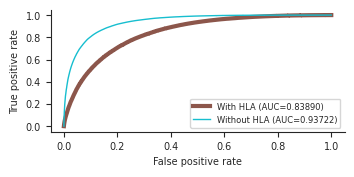

In [9]:
# Create and save figure

fig = plt.figure(figsize=fig_size, layout="constrained")

ax = fig.add_subplot()

x = ml_roc_curve_1_1_hla[ml_roc_curve_col_x]
y = ml_roc_curve_1_1_hla[ml_roc_curve_col_y]
auc = np.trapz(y, x)
label = f"With HLA (AUC={auc:.{auc_rounding}f})"
_ = ax.plot(x, y, color=line_color_hla, label=label, linewidth=linewidth_hla)

x = ml_roc_curve_1_1_no_hla[ml_roc_curve_col_x]
y = ml_roc_curve_1_1_no_hla[ml_roc_curve_col_y]
auc = np.trapz(y, x)
label = f"Without HLA (AUC={auc:.{auc_rounding}f})"
_ = ax.plot(x, y, color=line_color_no_hla, label=label, linewidth=linewidth_no_hla)

ax.legend(fontsize=legend_fontsize)

_ = ax.set_xlabel("False positive rate")
_ = ax.set_ylabel("True positive rate")

fig.get_layout_engine().set(w_pad=0, h_pad=0)

file_name = figures_main_dir.joinpath(f"{fig_name}.pdf")
fig.savefig(file_name)

### Machine Learning ROC Curve 1-5

In [10]:
# Load data

ml_roc_curve_1_5_hla = pl.read_csv(ml_roc_curve_1_5_hla_file)
ml_roc_curve_1_5_no_hla = pl.read_csv(ml_roc_curve_1_5_no_hla_file)

In [11]:
# Figure config

fig_size = figsize_in_mm(85, 40)

fig_name = "fig-3-ml-roc-curve-1-5"

line_color_hla = "C5"
line_color_no_hla = "C9"

linewidth_hla = 3
linewidth_no_hla = 1

legend_fontsize = 6

auc_rounding = 2

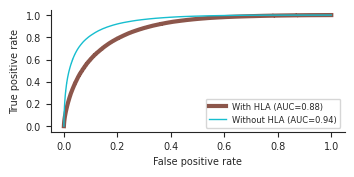

In [12]:
# Create and save figure

fig = plt.figure(figsize=fig_size, layout="constrained")

ax = fig.add_subplot()

x = ml_roc_curve_1_5_hla[ml_roc_curve_col_x]
y = ml_roc_curve_1_5_hla[ml_roc_curve_col_y]
auc = np.trapz(y, x)
label = f"With HLA (AUC={auc:.{auc_rounding}f})"
_ = ax.plot(x, y, color=line_color_hla, label=label, linewidth=linewidth_hla)

x = ml_roc_curve_1_5_no_hla[ml_roc_curve_col_x]
y = ml_roc_curve_1_5_no_hla[ml_roc_curve_col_y]
auc = np.trapz(y, x)
label = f"Without HLA (AUC={auc:.{auc_rounding}f})"
_ = ax.plot(x, y, color=line_color_no_hla, label=label, linewidth=linewidth_no_hla)

ax.legend(fontsize=legend_fontsize)

_ = ax.set_xlabel("False positive rate")
_ = ax.set_ylabel("True positive rate")

fig.get_layout_engine().set(w_pad=0, h_pad=0)

file_name = figures_main_dir.joinpath(f"{fig_name}.pdf")
fig.savefig(file_name)

### Clusters' Peptide Intersection (UMAP)

In [8]:
# Select which samples file to use

# Main
samples = pl.read_csv(samples_main_file)

# Supplementary
# samples = pl.read_csv(samples_supp_file)

In [9]:
# Prepare data

peptides_col = samples_col_peptides_9

samples = samples.with_columns(
    pl.col(samples_list_cols).str.split(samples_list_sep).fill_null(list())
)

# Samples with UMAP data only
samples = samples.filter(pl.col(samples_col_label).is_not_null())

embedding = samples[samples_col_umap_x, samples_col_umap_y].to_numpy()
labels = samples[samples_col_label].to_numpy()
peptides = samples[peptides_col].to_numpy()

del samples

unique_labels = sorted(set(labels))

all_cluster_peps_col_label = "Label"
all_cluster_peps_col_peps = "Peptides"
all_cluster_peps_col_x_perc = lambda label: f"Perc_{label}"
all_cluster_peps_cols_x_perc = [all_cluster_peps_col_x_perc(ul) for ul in unique_labels]

common_peps_perc_c_name = lambda label: f"C_{label}"

# Gather all cluster peptides
all_cluster_peps = []
for lab in unique_labels:
    mask = labels == lab
    clustered_peptides = []
    for pep_list in peptides[mask]:
        clustered_peptides.extend(pep_list)
    clustered_peptides = list(set(clustered_peptides))
    all_cluster_peps.append(clustered_peptides)

all_cluster_peps = pl.DataFrame(
    {
        all_cluster_peps_col_label: unique_labels,
        all_cluster_peps_col_peps: all_cluster_peps,
    }
)

# Calculate the percent of common peptides between clusters
common_peps_perc = []

for lab_org in unique_labels:
    row_org = all_cluster_peps.filter(
        pl.col(all_cluster_peps_col_label) == lab_org
    ).row(0, named=True)
    peps_org = row_org[all_cluster_peps_col_peps]

    peps_org_n = len(peps_org)

    c_peps_perc = []

    for lab in unique_labels:
        row = all_cluster_peps.filter(pl.col(all_cluster_peps_col_label) == lab).row(
            0, named=True
        )
        peps = row[all_cluster_peps_col_peps]

        n_common = len(set(peps_org).intersection(set(peps)))

        c_peps_perc.append(n_common / peps_org_n * 100)

    common_peps_perc.append(c_peps_perc)

all_cluster_peps = pl.concat(
    [all_cluster_peps, pl.DataFrame(common_peps_perc, all_cluster_peps_cols_x_perc)],
    how="horizontal",
)

# Prepare a table with common percentage
common_peps_perc = (
    all_cluster_peps.with_columns(
        pl.col(all_cluster_peps_col_label)
        .cast(pl.String)
        .map_elements(lambda x: common_peps_perc_c_name(x), return_dtype=pl.String)
    )
    .select(pl.col(all_cluster_peps_col_label), pl.col(all_cluster_peps_cols_x_perc))
    .rename({all_cluster_peps_col_x_perc(ul): common_peps_perc_c_name(ul) for ul in unique_labels})
    .to_pandas()
    .set_index(all_cluster_peps_col_label)
)
common_peps_perc.index.name = ""

del all_cluster_peps

In [ ]:
# See the original cluster IDs

fig = plt.figure(figsize=(5, 5), layout="constrained")

ax = fig.add_subplot()

colors = color_pallet(len(unique_labels))

for lab, c in zip(unique_labels, colors):
    if lab == -1:
        continue
    mask = labels == lab
    data = embedding[mask, :]

    hull = ConvexHull(data)
    ax.fill(
        [data[vert, 0] for vert in hull.vertices],
        [data[vert, 1] for vert in hull.vertices],
        color=c,
    )

    x, y = calculate_centroid(data)
    txt = ax.text(
        x,
        y,
        common_peps_perc_c_name(lab),
        ha="center",
        va="center",
        size=8,
        color="black",
    )

In [11]:
# Map original IDs to new ones to be changed later on

clust_id_map = {
    "C_7": "C_1",
    "C_14": "C_2",
    "C_5": "C_3",
    "C_9": "C_4",
    "C_1": "C_5",
    "C_0": "C_6",
    "C_6": "C_7",
    "C_11": "C_8",
    "C_3": "C_9",
    "C_8": "C_10",
    "C_13": "C_11",
    "C_2": "C_12",
    "C_10": "C_13",
    "C_4": "C_14",
    "C_12": "C_15",
}

In [12]:
# Figure config

fig_size = figsize_in_mm(40, 40)

fig_name = "fig-3-clusters-peptides-umap"

header_fontsize = 6
header_color = "black"

axis_label_fontsize = 5

In [13]:
# Save the common peptides table to add appropriate info later

# Round the numbers
dec_p = 1
common_peps_perc=common_peps_perc.round(dec_p)

common_peps_perc = common_peps_perc.rename(columns=clust_id_map).rename(
    index=clust_id_map
)

file_name = figures_main_dir.joinpath(f"{fig_name}-HELP.csv")
common_peps_perc.to_csv(file_name, index=True)

In [ ]:
# Create and save figure

fig = plt.figure(figsize=fig_size, layout="constrained")

ax = fig.add_subplot()

colors = color_pallet(len(unique_labels))

for lab, c in zip(unique_labels, colors):
    if lab == -1:
        continue
    mask = labels == lab
    data = embedding[mask, :]

    hull = ConvexHull(data)
    ax.fill(
        [data[vert, 0] for vert in hull.vertices],
        [data[vert, 1] for vert in hull.vertices],
        color=c,
    )

    x, y = calculate_centroid(data)
    txt = ax.text(
        x,
        y,
        clust_id_map[common_peps_perc_c_name(lab)],
        ha="center",
        va="center",
        size=header_fontsize,
        color=header_color,
    )

ax.margins(x=0.01, y=0.01)

ax.set_xticks([])
ax.set_yticks([])

_ = ax.set_xlabel("UMAP_1", fontsize=axis_label_fontsize)
_ = ax.set_ylabel("UMAP_2", fontsize=axis_label_fontsize)

fig.get_layout_engine().set(w_pad=0, h_pad=0)

file_name = figures_main_dir.joinpath(f"{fig_name}.pdf")
fig.savefig(file_name)

### Clusters' Peptide Intersection (All)

In [16]:
# Select which samples file to use

# Main
samples = pl.read_csv(samples_main_file)

# Supplementary
# samples = pl.read_csv(samples_supp_file)

In [17]:
# Prepare data

peptides_col = samples_col_peptides_9

samples = samples.with_columns(
    pl.col(samples_list_cols).str.split(samples_list_sep).fill_null(list())
)

# Samples with UMAP data only
samples = samples.filter(pl.col(samples_col_label).is_not_null())

labels = samples[samples_col_label].to_numpy()
peptides = samples[peptides_col].to_numpy()

del samples

unique_labels = sorted(set(labels))

all_cluster_peps_col_label = "Label"
all_cluster_peps_col_peps = "Peptides"
all_cluster_peps_col_x_perc = lambda label: f"Perc_{label}"
all_cluster_peps_cols_x_perc = [all_cluster_peps_col_x_perc(ul) for ul in unique_labels]

common_peps_perc_c_name = lambda label: f"C_{label}"

common_peps_perc_all_col_label = "Label"
common_peps_perc_all_col_perc = "Perc_all"

# Gather all cluster peptides
all_cluster_peps = []
for lab in unique_labels:
    mask = labels == lab
    clustered_peptides = []
    for pep_list in peptides[mask]:
        clustered_peptides.extend(pep_list)
    clustered_peptides = list(set(clustered_peptides))
    all_cluster_peps.append(clustered_peptides)

all_cluster_peps = pl.DataFrame(
    {
        all_cluster_peps_col_label: unique_labels,
        all_cluster_peps_col_peps: all_cluster_peps,
    }
)

# Calculate the percent of common peptides between clusters
common_peps_perc = []
common_peps_perc_all = []

for lab_org in unique_labels:
    row_org = all_cluster_peps.filter(
        pl.col(all_cluster_peps_col_label) == lab_org
    ).row(0, named=True)
    peps_org = row_org[all_cluster_peps_col_peps]

    peps_org_n = len(peps_org)

    c_peps_perc = []
    c_peps_all = []

    for lab in unique_labels:
        row = all_cluster_peps.filter(pl.col(all_cluster_peps_col_label) == lab).row(
            0, named=True
        )
        peps = row[all_cluster_peps_col_peps]

        n_common = len(set(peps_org).intersection(set(peps)))
        c_peps_perc.append(n_common / peps_org_n * 100)

        if lab != lab_org:
            c_peps_all.extend(peps)

    common_peps_perc.append(c_peps_perc)

    n_common_all = len(set(peps_org).intersection(set(c_peps_all)))
    common_peps_perc_all.append(n_common_all / peps_org_n * 100)

all_cluster_peps = pl.concat(
    [all_cluster_peps, pl.DataFrame(common_peps_perc, all_cluster_peps_cols_x_perc)],
    how="horizontal",
)

# Prepare a table with common percentage between clusters
common_peps_perc = (
    all_cluster_peps.with_columns(
        pl.col(all_cluster_peps_col_label)
        .cast(pl.String)
        .map_elements(lambda x: common_peps_perc_c_name(x), return_dtype=pl.String)
    )
    .select(pl.col(all_cluster_peps_col_label), pl.col(all_cluster_peps_cols_x_perc))
    .rename(
        {
            all_cluster_peps_col_x_perc(ul): common_peps_perc_c_name(ul)
            for ul in unique_labels
        }
    )
    .to_pandas()
    .set_index(all_cluster_peps_col_label)
)
common_peps_perc.index.name = ""

# Prepare a table with common percentage for all clusters
common_peps_perc_all = pl.DataFrame(
    {
        common_peps_perc_all_col_label: unique_labels,
        common_peps_perc_all_col_perc: common_peps_perc_all,
    }
)
common_peps_perc_all = common_peps_perc_all.with_columns(
    pl.col(common_peps_perc_all_col_label)
    .cast(pl.String)
    .map_elements(lambda x: common_peps_perc_c_name(x), return_dtype=pl.String)
)

del all_cluster_peps

In [18]:
# Map original IDs to new ones to be changed later on
# Taken from the previous section

clust_id_map = {
    "C_7": "C_1",
    "C_14": "C_2",
    "C_5": "C_3",
    "C_9": "C_4",
    "C_1": "C_5",
    "C_0": "C_6",
    "C_6": "C_7",
    "C_11": "C_8",
    "C_3": "C_9",
    "C_8": "C_10",
    "C_13": "C_11",
    "C_2": "C_12",
    "C_10": "C_13",
    "C_4": "C_14",
    "C_12": "C_15",
}

common_peps_perc = common_peps_perc.rename(columns=clust_id_map).rename(
    index=clust_id_map
)

common_peps_perc_all = common_peps_perc_all.with_columns(
    pl.col(common_peps_perc_all_col_label).replace(clust_id_map)
)

In [20]:
# Figure config

fig_size = figsize_in_mm(102.5, 60.6)

fig_name = "fig-3-clusters-peptides-all"

tick_label_fontsize = 5
axis_label_fontsize = 5

cbar_label_fontsize = 6
cbar_tick_label_fontsize = 6

cbar_pad = 0.02

bar_width = 0.5
block_height = bar_width

y_gap_width = 0.1

# cmap = plt.cm.inferno
cmap = sns.cm.rocket

color_100 = (0.5, 0.5, 0.5, 1)

height_ratios = [1, 0.7]

lower_tick_label_fontsize = 6
lower_axis_label_fontsize = 6

In [ ]:
# Produce helper figure for the dendrogram sorting and tree

cm = sns.clustermap(
    common_peps_perc.T,
    figsize=figsize_in_mm(115, 55),
    xticklabels=True,
    yticklabels=True,
    row_cluster=False,
    cbar=False,
)

cm.ax_row_dendrogram.set_visible(False)
cm.ax_cbar.set_visible(False)

file_name = figures_main_dir.joinpath(f"{fig_name}-HELP.pdf")
cm.figure.savefig(file_name)

In [ ]:
# Create and save figure

fig = plt.figure(figsize=fig_size, layout="constrained")

gs = fig.add_gridspec(nrows=2, ncols=1, hspace=0, wspace=0, height_ratios=height_ratios)
# axs = gs.subplots(sharex="all")

ax = fig.add_subplot(gs[0])

# vmin = common_peps_perc.min().min()
# vmax = common_peps_perc.replace(100.0, np.nan).max().max()
# vmin = 0
# vmax = 100
vmin = min(
    common_peps_perc.min().min(),
    common_peps_perc_all[common_peps_perc_all_col_perc].min(),
)
vmax = max(
    common_peps_perc.replace(100.0, np.nan).max().max(),
    common_peps_perc_all[common_peps_perc_all_col_perc].max(),
)

norm = plt.matplotlib.colors.Normalize(vmin=vmin, vmax=vmax)

sorted_cols = [t.get_text() for t in cm.ax_heatmap.xaxis.get_ticklabels()]

pep_perc_sorted = common_peps_perc.loc[sorted_cols]

y_labels = sorted_cols

y_ticks = (
    np.arange(0, pep_perc_sorted.shape[1]) * block_height
    + np.arange(0, pep_perc_sorted.shape[1]) * y_gap_width
    + block_height / 2
)

heights = np.full(pep_perc_sorted.shape[0], block_height)

y = 0

for c in y_labels:
    colors = (
        pep_perc_sorted.loc[:, c]
        .map(lambda x: color_100 if x == 100.0 else cmap(norm(x)))
        .to_list()
    )

    ax.bar(sorted_cols, heights, width=bar_width, bottom=y, color=colors)

    y = y + block_height + y_gap_width

ax.set_yticks(y_ticks, y_labels)

_ = ax.set_ylabel("Clusters", size=axis_label_fontsize)

ax.tick_params(axis="y", labelsize=tick_label_fontsize)

ax.tick_params(bottom=False, labelbottom=False)

ax_lower = fig.add_subplot(gs[1], sharex=ax)

pep_perc_sorted = common_peps_perc_all.sort(
    pl.col(common_peps_perc_all_col_label).cast(pl.Enum(sorted_cols))
)

colors = [cmap(norm(x)) for x in pep_perc_sorted[common_peps_perc_all_col_perc]]

_ = ax_lower.bar(
    pep_perc_sorted[common_peps_perc_all_col_label],
    pep_perc_sorted[common_peps_perc_all_col_perc],
    width=bar_width,
    color=colors,
)

y_ticks_lower = [20, 40, 60, 80]
ax_lower.set_yticks(y_ticks_lower, y_ticks_lower)

ax_lower.yaxis.set_inverted(True)

_ = ax_lower.set_ylabel("Common\npeptides (%)", size=lower_axis_label_fontsize)

ax_lower.spines[["top"]].set_visible(True)
ax_lower.spines[["bottom"]].set_visible(False)

ax_lower.tick_params(bottom=False, pad=0)

ax_lower.tick_params(axis="x", labelsize=tick_label_fontsize, rotation=90)
ax_lower.tick_params(
    axis="y", reset=True, labelsize=lower_tick_label_fontsize, right=False
)

ax.margins(x=0, y=0)
ax_lower.margins(x=0, y=0)

cbar = fig.colorbar(
    plt.cm.ScalarMappable(norm=norm, cmap=cmap),
    ax=[ax, ax_lower],
    orientation="vertical",
    shrink=0.7,
    pad=cbar_pad,
)
cbar.set_label("Common peptides (%)", size=cbar_label_fontsize)
cbar.ax.tick_params(axis="y", labelsize=cbar_tick_label_fontsize)

fig.get_layout_engine().set(w_pad=0, h_pad=0, hspace=0, wspace=0)

file_name = figures_main_dir.joinpath(f"{fig_name}.pdf")
fig.savefig(file_name)

## Supplementary Figures

### Percentage of AA Combinations

In [143]:
# Select which number of positions options to draw

n_positions = [2, 3, 4, 5, 6, 7, 8]

In [144]:
# Prepare necessary data

# Gather statistics for amino acids combinations
aa_perc_col = "AA_perc"

aa_comb_perc = []

for n_p in n_positions:
    # Prepare the amino acids combinations table
    aa_combinations = pl.read_csv(aa_combinations_file(n_p))
    comb_num = (
        aa_combinations.group_by(aa_combinations_col_pos, maintain_order=True)
        .agg(pl.col(aa_combinations_col_aa))
        .with_columns(pl.col(aa_combinations_col_aa).list.len())
    )

    max_comb_n = len(AMINO_ACIDS) ** n_p
    comb_num = comb_num.with_columns(
        (pl.col(aa_combinations_col_aa) / max_comb_n * 100).alias(aa_perc_col)
    )

    aa_comb_perc.append(comb_num)

del aa_combinations, comb_num

In [145]:
# Figure config

fig_size = figsize_in_mm(max_fig_width_double_col, max_max_fig_height)

fig_name = "supp-aa-combinations-percentage"

sort = True
sort_low_to_high = True

pos_ticks_labelsize = 4
perc_ticks_labelsize = 5

# c_29 = "C3"
# c_9 = "C1"
# c_2 = "C2"
# c_r = "C0"
c_29 = plt.cm.Set2(5)
c_9 = plt.cm.Set2(1)
c_2 = plt.cm.Set2(0)
c_r = plt.cm.Set2(2)

In [ ]:
plt.colormaps["Set2"]

In [ ]:
# Create and save figure

nrows = len(n_positions)
ncols = 1

fig = plt.figure(figsize=fig_size, layout="constrained")

gs = fig.add_gridspec(nrows=nrows, ncols=ncols)
axs = gs.subplots()

for n_p, aa_perc, ax in zip(n_positions, aa_comb_perc, axs.flatten()):
    if sort:
        if sort_low_to_high:
            descending = [False, False]
        else:
            descending = [True, False]
        aa_perc = aa_perc.sort(
            aa_perc_col, aa_combinations_col_pos, descending=descending
        )

    x = np.arange(aa_perc.shape[0])

    if n_p == 7:
        tick_labels = []
        for ac in aa_perc[aa_combinations_col_pos]:
            ac_list = ac.split(aa_combinations_list_sep)
            new_lab = ", ".join(ac_list[:3]) + ",\n" + ", ".join(ac_list[3:])
            tick_labels.append(new_lab)
    else:
        tick_labels = [
            ac.replace(aa_combinations_list_sep, ", ")
            for ac in aa_perc[aa_combinations_col_pos]
        ]

    colors = []
    for pc in aa_perc[aa_combinations_col_pos]:
        pc_list = pc.split(aa_combinations_list_sep)
        if "9" in pc_list:
            if "2" in pc_list:
                colors.append(c_29)
            else:
                colors.append(c_9)
        elif "2" in pc_list:
            colors.append(c_2)
        else:
            colors.append(c_r)

    rects = ax.bar(x, aa_perc[aa_perc_col], tick_label=tick_labels, color=colors)

    if n_p == 2:
        ax.bar_label(
            rects,
            labels=aa_perc[aa_perc_col].to_list(),
            fontsize=perc_ticks_labelsize,
            label_type="center",
            rotation=90,
        )

    ax.grid(axis="y")
    if n_p == 8 or n_p == 2 or n_p == 1:
        rotation = 0
    else:
        rotation = 90
    ax.tick_params(axis="x", labelsize=pos_ticks_labelsize, rotation=rotation)
    ax.tick_params(axis="y", labelsize=perc_ticks_labelsize)
    ax.margins(x=0)
    ax.spines[["right", "top"]].set_visible(True)
    if n_p == 8 or n_p == 7:
        ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0), useMathText=True)
        ax.figure.draw_without_rendering()  # This needs to be done cause `offset text` is only created when drawing...
        t = ax.yaxis.get_offset_text().get_text()
        ax.yaxis.get_offset_text().set_visible(False)
        ax.annotate(
            t,
            xy=(0, 0.5),
            xycoords="axes fraction",
            xytext=(-3, 0),
            textcoords="offset fontsize",
            fontsize=perc_ticks_labelsize,
            va="center",
            ha="right",
            fontstyle="italic",
            rotation=90,
        )

_ = fig.supxlabel("Positions in peptide sequence")
_ = fig.supylabel("Portion of all possible amino acid combinations (%)")

fig.get_layout_engine().set(w_pad=0, h_pad=0.02, hspace=0.03)

file_name = figures_supp_dir.joinpath(f"{fig_name}.pdf")
fig.savefig(file_name)

file_name = figures_supp_dir.joinpath(f"{fig_name}.png")
fig.savefig(file_name, dpi=600)

file_name = figures_supp_dir.joinpath(f"{fig_name}.tif")
fig.savefig(file_name, dpi=600, pil_kwargs={"compression": "tiff_lzw"})

file_name = figures_supp_dir.joinpath(f"{fig_name}.eps")
fig.savefig(file_name)

### Best AA Combinations

In [148]:
# Select which number of positions options to draw

n_positions = [1, 2, 3, 4, 5, 6, 7, 8]

In [149]:
# Prepare necessary data

pep_perc_col = "Peptides_perc"

pep_col = samples_col_peptides_9

# Get unique peptides
samples = pl.read_csv(samples_supp_file)
samples = samples.with_columns(
    pl.col(samples_list_cols).str.split(samples_list_sep).fill_null(list())
)
samples = samples.filter(pl.col(pep_col).list.len() != 0)
peptides = []
for pep_list in samples[pep_col]:
    peptides.extend(pep_list)
peptides = np.array(sorted(set(peptides)))
del samples

peptides_n = len(peptides)

del peptides

best_aa_combs = []

for n_p in n_positions:
    # Prepare the amino acids combinations table
    aa_combinations = pl.read_csv(aa_combinations_file(n_p))
    aa_combinations = aa_combinations.with_columns(
        pl.col(aa_combinations_col_pep).str.split(aa_combinations_list_sep)
    )

    aa_combinations = aa_combinations.with_columns(
        (pl.col(aa_combinations_col_pep).list.len() / peptides_n * 100).alias(
            pep_perc_col
        )
    )

    # Get the best amino acid combination for all unique positions
    best_aac = (
        aa_combinations.group_by(aa_combinations_col_pos)
        .agg(pl.all().sort_by(pep_perc_col).last())
        .select(pl.col([aa_combinations_col_pos, aa_combinations_col_aa, pep_perc_col]))
    )
    best_aac = best_aac.sort(aa_combinations_col_pos)
    if n_p == 1:
        best_aac = best_aac.with_columns(
            pl.col(aa_combinations_col_pos).cast(pl.String)
        )
    best_aa_combs.append(best_aac)

del aa_combinations, best_aac

In [150]:
# Figure config

fig_size = figsize_in_mm(max_fig_width_double_col, max_max_fig_height)

fig_name = "supp-best-aa-combinations"

sort = True
sort_low_to_high = False

pos_ticks_labelsize = 4
perc_ticks_labelsize = 5

aa_font_size = 4

# c_29 = "C3"
# c_9 = "C1"
# c_2 = "C2"
# c_r = "C0"
c_29 = plt.cm.Set2(5)
c_9 = plt.cm.Set2(1)
c_2 = plt.cm.Set2(0)
c_r = plt.cm.Set2(2)

In [ ]:
# Create and save figure

nrows = 1
ncols = len(n_positions)

width_ratios = [0.4, 0.75, 0.9, 1, 1, 1, 1, 0.4]

fig = plt.figure(figsize=fig_size, layout="constrained")

gs = fig.add_gridspec(nrows=nrows, ncols=ncols, width_ratios=width_ratios)
axs = gs.subplots()

for n_p, aa_perc, ax in zip(n_positions, best_aa_combs, axs.flatten()):
    if sort:
        if sort_low_to_high:
            descending = False
        else:
            descending = True
        aa_perc = aa_perc.sort(pep_perc_col, descending=descending)

    x = np.arange(aa_perc.shape[0])

    if n_p == 7:
        tick_labels = []
        for ac in aa_perc[aa_combinations_col_pos]:
            ac_list = ac.split(aa_combinations_list_sep)
            # new_lab = ", ".join(ac_list[:3]) + ",\n" + ", ".join(ac_list[3:])
            new_lab = ", ".join(ac_list[:2]) + ",\n" + ", ".join(ac_list[2:4]) + ",\n" + ", ".join(ac_list[4:])
            tick_labels.append(new_lab)
    else:
        tick_labels = [
            ac.replace(aa_combinations_list_sep, ", ")
            for ac in aa_perc[aa_combinations_col_pos]
        ]

    colors = []
    for pc in aa_perc[aa_combinations_col_pos]:
        pc_list = pc.split(aa_combinations_list_sep)
        if "9" in pc_list:
            if "2" in pc_list:
                colors.append(c_29)
            else:
                colors.append(c_9)
        elif "2" in pc_list:
            colors.append(c_2)
        else:
            colors.append(c_r)

    rects = ax.barh(x, aa_perc[pep_perc_col], tick_label=tick_labels, color=colors)

    # Add amino acids
    if n_p == 8:
        rotation = 90
    else:
        rotation = 0
    for r, aa in zip(rects, aa_perc[aa_combinations_col_aa]):
        aa_str = aa.replace(aa_combinations_list_sep, ", ")
        _ = ax.annotate(
            aa_str,
            xy=(0, r.get_y() + r.get_height() / 2),
            xytext=(0.5, 0),
            textcoords="offset fontsize",
            ha="left",
            va="center",
            fontsize=aa_font_size,
            rotation=rotation,color="0.25",fontfamily="monospace"
        )

    ax.grid(axis="x")
    if n_p == 8 or n_p == 2 or n_p == 7:
        rotation = 90
    else:
        rotation = 0
    ax.tick_params(axis="y", labelsize=pos_ticks_labelsize, rotation=rotation)
    if n_p == 8 or n_p == 2 or n_p == 7:
        tlab = ax.get_yticklabels()
        ax.set_yticklabels(tlab, va="center")
    ax.tick_params(axis="x", labelsize=perc_ticks_labelsize)
    ax.margins(y=0.0025)
    ax.spines[["right", "top"]].set_visible(True)

    # Change scientific notation
    if n_p == 8:
        ax.ticklabel_format(axis="x", style="sci", scilimits=(0, 0), useMathText=True)
        ax.figure.draw_without_rendering()  # This needs to be done cause `offset text` is only created when drawing...
        t = ax.xaxis.get_offset_text().get_text()
        ax.xaxis.get_offset_text().set_visible(False)
        ax.annotate(
            t,
            xy=(0.5, 0),
            xycoords="axes fraction",
            xytext=(0, -3),
            textcoords="offset fontsize",
            fontsize=perc_ticks_labelsize,
            va="top",
            ha="center",
            fontstyle="italic",
        )

_ = fig.supylabel("Positions in peptide sequence")
_ = fig.supxlabel("Peptide coverage (%)", y=0)

fig.get_layout_engine().set(w_pad=0.02, h_pad=0.02, wspace=0.03)

file_name = figures_supp_dir.joinpath(f"{fig_name}.pdf")
fig.savefig(file_name)

file_name = figures_supp_dir.joinpath(f"{fig_name}.png")
fig.savefig(file_name, dpi=600)

file_name = figures_supp_dir.joinpath(f"{fig_name}.tif")
fig.savefig(file_name, dpi=600, pil_kwargs={"compression": "tiff_lzw"})

file_name = figures_supp_dir.joinpath(f"{fig_name}.eps")
fig.savefig(file_name)

### AA Combination Frequency (all)

This might take a while to generate.

In [152]:
# Select the number of positions option to draw

n_positions = [1, 2, 3, 4, 5, 6, 7, 8]

# Select cut-off threshold for annotating the cumulative percent of peptides coverage

sum_margin = 90

In [ ]:
# Prepare necessary data

pep_perc_col = "Peptides_perc"

pep_col = samples_col_peptides_9

pep_len = peptide_len

blank_char = "_"

first_pos_n = 1

# Get unique peptides
samples = pl.read_csv(samples_supp_file)
samples = samples.with_columns(
    pl.col(samples_list_cols).str.split(samples_list_sep).fill_null(list())
)
samples = samples.filter(pl.col(pep_col).list.len() != 0)
peptides = []
for pep_list in samples[pep_col]:
    peptides.extend(pep_list)
peptides = np.array(sorted(set(peptides)))
del samples

peptides_n = len(peptides)

aa_combinations_all = []
peptide_coverage_all = []
above_margin_idx_all = []
below_margin_comb_perc_all = []
comb_peps_pssm_all = []
comb_n_all = []

for n_p in tqdm(n_positions):
    # Prepare the amino acids combinations table
    aa_combinations = pl.read_csv(aa_combinations_file(n_p))
    aa_combinations = aa_combinations.with_columns(
        pl.col(aa_combinations_col_pep).str.split(aa_combinations_list_sep)
    )

    if n_p == 1:
        aa_combinations = aa_combinations.with_columns(
            pl.col(aa_combinations_col_pos).cast(pl.List(int)),
            pl.col(aa_combinations_col_aa).str.split(";"),
        )
    else:
        aa_combinations = aa_combinations.with_columns(
            pl.col(aa_combinations_col_pos).str.split(";").cast(pl.List(int)),
            pl.col(aa_combinations_col_aa).str.split(";"),
        )

    aa_combinations = aa_combinations.with_columns(
        (pl.col(aa_combinations_col_pep).list.len() / peptides_n * 100).alias(
            pep_perc_col
        )
    )
    aa_combinations = aa_combinations.sort(pep_perc_col, descending=True)

    aa_combinations_all.append(aa_combinations)

    comb_n = aa_combinations.shape[0]

    comb_n_all.append(comb_n)

    # Get the cumulative percent of peptides coverage
    peptide_coverage = []
    pep_c = set()
    for pep_list in aa_combinations[aa_combinations_col_pep]:
        pep_c.update(pep_list)
        p_perc = len(pep_c) / peptides_n * 100
        if p_perc >= 100:
            n_left = aa_combinations.shape[0] - len(peptide_coverage)
            peptide_coverage.extend([100.0] * n_left)
            break
        peptide_coverage.append(p_perc)
    peptide_coverage = np.array(peptide_coverage)

    peptide_coverage_all.append(peptide_coverage)

    # Check the above threshold index
    above_margin_idx = np.where(peptide_coverage >= sum_margin)[0][0]
    # margin_diff = peptide_coverage[above_margin_idx] - sum_margin
    # prev_diff = peptide_coverage[above_margin_idx] - peptide_coverage[above_margin_idx - 1]
    # margin_val = above_margin_idx - margin_diff / prev_diff

    above_margin_idx_all.append(above_margin_idx)

    below_margin_comb_perc = (above_margin_idx + 1) / comb_n * 100

    below_margin_comb_perc_all.append(below_margin_comb_perc)

    # Make "fake" peptides from amino acids combinations below threshold only
    blank_pep = np.array([blank_char] * pep_len)

    below_margin_aa_combs = aa_combinations.slice(0, above_margin_idx + 1)

    comb_peps = []
    for i in range(below_margin_aa_combs.shape[0]):
        row = below_margin_aa_combs.row(i)
        new_pep = blank_pep.copy()
        new_pep[np.array(row[0]) - first_pos_n] = row[1]
        comb_peps.append("".join(new_pep))

    # Create a PSSM table out of those peptides
    comb_peps_pssm = info_pssm(comb_peps, alphabet=AMINO_ACIDS + [blank_char])
    aa_cols = comb_peps_pssm.columns.to_list()
    aa_cols.remove(blank_char)
    comb_peps_pssm = comb_peps_pssm.loc[:, aa_cols]

    comb_peps_pssm_all.append(comb_peps_pssm)

del aa_combinations, peptide_coverage, comb_peps_pssm

In [154]:
# Figure config

fig_size = figsize_in_mm(max_fig_width_double_col, max_max_fig_height)

fig_name = "supp-aa-combinations-coverage-all"

marker_size = 4

pos_n_label_pos = (0.9, 0.8)
pos_n_label_color = "black"
pos_n_label_fontsize = 7

best_combs_n = 4
best_combs_pos = (0.36, 0.85)
best_combs_fontsize = 6
best_combs_color = "black"

logo_x = 0.8
logo_size = (70 / 72 * logo_x, 50 / 72 * logo_x)  # Pixels
logo_location = (0.81, 0.6)
logo_font_size = 5

sum_annot_color = "black"
sum_annot_linewidth = 1.25
sum_annot_font_size = 6
sum_annot_arrow_x_offset = 0.003125  # This is in % of data points
sum_annot_arrow_lenth = 15
sum_annot_arrowprops = dict(
    facecolor=sum_annot_color, headwidth=4, headlength=4, width=0.5
)
sum_annot_arrow_pos_pep = 0.77
sum_annot_arrow_pos_comb = 0.5

ax2_linewidth = 1.8
ax2_color = "0.4"
ax2_label_x_stretch = 0.98  # the smaller the number, the greater the stretch

comb_n_x_fontsize = 6
sci_not_pos = (0.4, -1.1)

axes_x_margin = 0.01

downsample_save_first_n = 1_000
downsample_output_n = 10_000

In [ ]:
# Create and save figure

temp_sep = ";"

nrows = len(n_positions)
ncols = 1

fig = plt.figure(figsize=fig_size, layout="constrained")

gs = fig.add_gridspec(nrows=nrows, ncols=ncols)
axs = gs.subplots()

for (
    n_p,
    aa_combinations,
    peptide_coverage,
    above_margin_idx,
    below_margin_comb_perc,
    comb_peps_pssm,
    comb_n,
    ax,
) in tzip(
    n_positions,
    aa_combinations_all,
    peptide_coverage_all,
    above_margin_idx_all,
    below_margin_comb_perc_all,
    comb_peps_pssm_all,
    comb_n_all,
    axs.flatten(),
):
    x = np.arange(comb_n)

    # Make each indices combination have its own color
    unique_pos = aa_combinations[aa_combinations_col_pos].unique(maintain_order=True)
    unique_pos_n = len(unique_pos)
    colors = color_pallet(unique_pos_n)

    # Downsampling points (but leaving first N)
    if n_p > 1:
        rest_n = comb_n - downsample_save_first_n
        downsample_every_n = max(1, int(rest_n / downsample_output_n))
        downsample_cycle_values = itertools.cycle(
            [False] * (downsample_every_n - 1) + [True]
        )
        downsample_mask = list(itertools.islice(downsample_cycle_values, rest_n))
        downsample_mask = [True] * downsample_save_first_n + downsample_mask
        downsample_mask[-1] = True
        x = x[downsample_mask]
        aa_combinations = aa_combinations.filter(downsample_mask)

    # Map all positions to colors
    comb_colors = (
        aa_combinations[aa_combinations_col_pos]
        .cast(pl.List(pl.String))
        .list.join(temp_sep)
    )
    comb_colors = (
        comb_colors.replace(
            old=unique_pos.cast(pl.List(pl.String)).list.join(temp_sep),
            new=pl.Series(colors).cast(pl.List(pl.String)).list.join(temp_sep),
        )
        .str.split(temp_sep)
        .cast(pl.List(pl.Float64))
        .to_list()
    )

    _ = ax.scatter(x, aa_combinations[pep_perc_col], s=marker_size, c=comb_colors)

    # Cumulative frequency of occurrence

    ax2 = ax.twinx()

    ax2.spines["right"].set_visible(True)
    ax2.spines["right"].set_color(ax2_color)
    ax2.tick_params(axis="y", colors=ax2_color)

    _ = ax2.plot(peptide_coverage, color=ax2_color, linewidth=ax2_linewidth)

    # X% peptide sum annotations

    _ = ax2.axvline(
        above_margin_idx, color=sum_annot_color, linewidth=sum_annot_linewidth
    )

    ybound = ax.get_ybound()

    arrow_offset = sum_annot_arrow_x_offset * comb_n

    _ = ax.annotate(
        f"{sum_margin}% of peptides",
        xy=(
            above_margin_idx + arrow_offset,
            ybound[0] + (ybound[1] - ybound[0]) * sum_annot_arrow_pos_pep,
        ),
        xytext=(sum_annot_arrow_lenth, 0),
        textcoords="offset points",
        ha="left",
        va="center",
        fontsize=sum_annot_font_size,
        color=sum_annot_color,
        arrowprops=sum_annot_arrowprops,
    )

    _ = ax.annotate(
        f"{below_margin_comb_perc:.2f}% of combinations\n("
        + r"$\bf{"
        + f"{above_margin_idx+1:,}"
        + "}$)",
        xy=(
            above_margin_idx + arrow_offset,
            ybound[0] + (ybound[1] - ybound[0]) * sum_annot_arrow_pos_comb,
        ),
        xytext=(sum_annot_arrow_lenth, 0),
        textcoords="offset points",
        ha="left",
        va="center",
        fontsize=sum_annot_font_size,
        color=sum_annot_color,
        arrowprops=sum_annot_arrowprops,
    )

    ax.margins(x=axes_x_margin)
    ax2.margins(x=axes_x_margin)

    # Motif logo

    trans = fig.dpi_scale_trans + ScaledTranslation(
        logo_location[0], logo_location[1], ax.transAxes
    )
    motif_ax = inset_axes(
        ax,
        width="100%",
        height="100%",
        bbox_to_anchor=(
            -logo_size[0] / 2,
            -logo_size[1] / 2,
            logo_size[0],
            logo_size[1],
        ),
        bbox_transform=trans,
        borderpad=0,
        axes_kwargs={"anchor": "C"},
        loc="center",
    )

    motif_ax.spines[["right", "top"]].set_visible(True)

    # Create a motif from amino acids combinations below threshold only
    logo = logomaker.Logo(
        comb_peps_pssm,
        color_scheme="weblogo_protein",
        stack_order="big_on_top",
        flip_below=False,
        center_values=False,
        baseline_width=0,
        vpad=0.05,
        ax=motif_ax,
    )

    logo.ax.set_xticks(
        range(0, pep_len), labels=[str(i) for i in range(1, pep_len + 1)]
    )
    logo.ax.xaxis.set_tick_params(length=0)
    _ = logo.ax.set_ylabel("Bits", size=logo_font_size, labelpad=0)
    logo.ax.tick_params(axis="both", labelsize=logo_font_size)

    # Add number of positions label
    label = f"{n_p} position"
    if n_p > 1:
        label += "s"
    _ = ax.text(
        pos_n_label_pos[0],
        pos_n_label_pos[1],
        label,
        transform=ax.transAxes,
        ha="left",
        va="top",
        color=pos_n_label_color,
        size=pos_n_label_fontsize,
    )

    # Add best combinations
    best_combs = []
    for row in aa_combinations.slice(0, best_combs_n).iter_rows():
        combs = [f"{p}({aa})" for p, aa in zip(row[0], row[1])]
        combs = ", ".join(combs)
        combs = "  " + combs
        best_combs.append(combs)
    best_combs = "\n".join(best_combs)
    best_combs_str = f"Best {best_combs_n} combinations:\n{best_combs}"
    _ = ax.text(
        best_combs_pos[0],
        best_combs_pos[1],
        best_combs_str,
        transform=ax.transAxes,
        ha="left",
        va="top",
        color=best_combs_color,
        size=best_combs_fontsize,
    )

    ax.spines[["top"]].set_visible(True)

    if n_p == 2 or n_p == 3:
        ax.xaxis.set_major_formatter(lambda x, _: f"{int(x):,}")

    # Change scientific notation
    if n_p == 4 or n_p == 5 or n_p == 6 or n_p == 7 or n_p == 8:
        ax.ticklabel_format(axis="x", style="sci", scilimits=(0, 0), useMathText=True)
        ax.figure.draw_without_rendering()  # This needs to be done cause `offset text` is only created when drawing...
        t = ax.xaxis.get_offset_text().get_text()
        ax.xaxis.get_offset_text().set_visible(False)
        ax.annotate(
            t,
            xy=(1, 0),
            xycoords="axes fraction",
            xytext=sci_not_pos,
            textcoords="offset fontsize",
            fontsize=comb_n_x_fontsize,
            va="top",
            ha="left",
            fontstyle="italic",
        )

_ = fig.supxlabel("Amino acids and positions combination")
_ = fig.supylabel("Peptide coverage (%)")
_ = fig.text(
    1,
    0.5,
    "Cumulative peptide coverage (%)",
    color=ax2_color,
    rotation=90,
    ha="center",
    va="bottom",
    rotation_mode="anchor",
)

fig.get_layout_engine().set(
    w_pad=0.02, h_pad=0.02, hspace=0.03, rect=(0, 0, ax2_label_x_stretch, 1)
)

file_name = figures_supp_dir.joinpath(f"{fig_name}.pdf")
fig.savefig(file_name)

file_name = figures_supp_dir.joinpath(f"{fig_name}.png")
fig.savefig(file_name, dpi=600)

file_name = figures_supp_dir.joinpath(f"{fig_name}.tif")
fig.savefig(file_name, dpi=600, pil_kwargs={"compression": "tiff_lzw"})

file_name = figures_supp_dir.joinpath(f"{fig_name}.eps")
fig.savefig(file_name)

### Populations Frequencies Bars

In [4]:
# Select which samples file to use

# Main
samples = pl.read_csv(samples_main_file)

# Supplementary
# samples = pl.read_csv(samples_supp_file)

# Select which frequency data to use

# samples_cols_freqs = samples_cols_freqs_a  # Only A* alleles
# freqs_pop_desc_cols_alleles = [freqs_pop_desc_col_a_b_drb1]

# samples_cols_freqs = samples_cols_freqs_b  # Only B* alleles
# freqs_pop_desc_cols_alleles = [freqs_pop_desc_col_a_b_drb1]

# samples_cols_freqs = samples_cols_freqs_c  # Only C* alleles
# freqs_pop_desc_cols_alleles = [freqs_pop_desc_col_c]

# samples_cols_freqs = samples_cols_freqs_abc_any  # A+B+C union
samples_cols_freqs = samples_cols_freqs_abc_all  # A+B+C intersection
freqs_pop_desc_cols_alleles = [freqs_pop_desc_col_a_b_drb1, freqs_pop_desc_col_c]

In [5]:
# Prepare data

pop_samples_n_col = "Samples_number"

# Samples frequencies data

freqs = samples[samples_cols_freqs]

del samples

new_cols = {c: c.split("_")[1] for c in freqs.columns}
freqs = freqs.rename(new_cols)

freqs = freqs.filter(pl.all_horizontal(pl.col("*").is_not_null()))

# Change the ordering based on clustering
pop_order = cos_sim_clustermap_order(freqs)
freqs = freqs.select(pl.col(pop_order))

# Original database populations samples numbers

freqs_pop_desc = pl.read_csv(freqs_pop_desc_file)

freqs_pop_desc_samples_n = freqs_pop_desc.select(
    pl.col(freqs_pop_desc_col_pop_code),
    pl.sum_horizontal(pl.col(freqs_pop_desc_cols_alleles)).alias(pop_samples_n_col),
)

freqs_pop_desc_samples_n = freqs_pop_desc_samples_n.select(
    pl.col(pop_samples_n_col)
).transpose(column_names=freqs_pop_desc_samples_n[freqs_pop_desc_col_pop_code])

del freqs_pop_desc

In [6]:
# Figure config

fig_size = figsize_in_mm(max_fig_width_double_col, max_max_fig_height * 0.45)

fig_name = "supp-pop-freqs"

bar_width = 30
bar_color = plt.cm.Set2(2)

freq_threshold = 0.05
# freq_threshold_color = "C3"
# freq_threshold_color = plt.cm.Set2(1)
# freq_threshold_color = plt.cm.Set2(5)
freq_threshold_color = plt.cm.Set2(7)
freq_threshold_linewidth = 1

gs_grid = (5, 5)  # (nrows, ncols); there are 21 populations

pop_label_size = 6
pop_label_x = 0.95
pop_label_y = 0.9
pop_label_color = "black"
pop_label_kwargs = dict(
    ha="right", va="top", color=pop_label_color, size=pop_label_size
)

x_label_hori_i = 0
y_label_vert_i = 2

axes_x_margin = 0.03

extra_axis_size = (0.27, 0.15)  # (width, height)
extra_axis_y = 0.094
extra_axis_fontsize = 5

above_thrsh_axis_loc = (0.35, extra_axis_y)  # (left, bottom)

freq_samples_axis_loc = (0.728, extra_axis_y)  # (left, bottom)

fig_canvas_rect = (-0.013, 0.07, 1.013, 1.029)

In [ ]:
# Create and save figure

warnings.filterwarnings(
    "ignore", category=UserWarning, message="This figure includes Axes"
)

populations = freqs.columns

fig = plt.figure(figsize=fig_size, layout="tight")

gs = fig.add_gridspec(nrows=gs_grid[0], ncols=gs_grid[1], hspace=0, wspace=0)
axs = gs.subplots(sharex="all", sharey="all")

# Main panels

x = np.arange(freqs.shape[0])

for ax, pop in zip(axs.flatten(), populations):
    ax.spines[["right", "top"]].set_visible(True)
    ax.set_xticks([])
    # ax.set_yticks([])

    pop_freqs = freqs[pop].to_numpy()

    _ = ax.bar(x, pop_freqs, width=bar_width, color=bar_color)
    # _ = ax.stem(x, pop_freqs, linefmt="C0-", basefmt="None", markerfmt="None")

    ax.axhline(
        freq_threshold, color=freq_threshold_color, linewidth=freq_threshold_linewidth
    )

    ax.text(pop_label_x, pop_label_y, pop, transform=ax.transAxes, **pop_label_kwargs)

y_ticks = axs.flatten()[0].get_yticks().tolist()
y_ticks.remove(0)
y_ticks.remove(0.2)
y_ticks.append(freq_threshold)
y_ticks = sorted(y_ticks)
axs.flatten()[0].set_yticks(y_ticks)

y_top = axs.flatten()[0].get_ylim()[1]
for ax in axs.flatten():
    # ax.set_ylim(0, y_top)
    ax.margins(x=axes_x_margin)

axs[-1][x_label_hori_i].set_xlabel("Sample")
axs[y_label_vert_i][0].set_ylabel("Frequency")

for ax in axs.flatten()[[1, 2, 3, 4, 6, 7, 8, 9, 11, 12, 13, 14, 16, 17, 18, 19]]:
    ax.tick_params(axis="y", left=False)
    # ax.set_yticks([])

# Automatically delete last unused axes
n_ax_to_del = gs_grid[0] * gs_grid[1] - len(populations)
if n_ax_to_del != 0:
    for ax in axs.flatten()[-n_ax_to_del:]:
        ax.set_axis_off()

axs.flatten()[0].annotate(
    "a",
    xy=(0, 1),
    xycoords="axes fraction",
    xytext=(-2.7, 0),
    textcoords="offset fontsize",
    **label_kwargs,
)

# Samples above threshold

ax = fig.add_axes(
    (
        above_thrsh_axis_loc[0],
        above_thrsh_axis_loc[1],
        extra_axis_size[0],
        extra_axis_size[1],
    )
)

pops_col = "Population"
at_col = "Samples"

above_thrsh_samples = (freqs >= freq_threshold).sum()
above_thrsh_samples = above_thrsh_samples.transpose(
    include_header=True, header_name=pops_col, column_names=[at_col]
)
above_thrsh_samples = above_thrsh_samples.sort(
    [at_col, pops_col], descending=[True, False]
)

x = np.arange(above_thrsh_samples.shape[0])

at_order_pop = above_thrsh_samples[pops_col].to_list()

_ = ax.bar(x, above_thrsh_samples[at_col], color=bar_color, tick_label=at_order_pop)

ax.margins(x=axes_x_margin / 2)

ax.tick_params(axis="x", labelsize=extra_axis_fontsize, rotation=90)
ax.tick_params(axis="y", labelsize=extra_axis_fontsize)
ax.set_ylabel("No. of samples", fontsize=extra_axis_fontsize)

ax.annotate(
    "b",
    xy=(0, 1),
    xycoords="axes fraction",
    xytext=(-3, 0),
    textcoords="offset fontsize",
    **label_kwargs,
)

# Number of samples from the original database

ax = fig.add_axes(
    (
        freq_samples_axis_loc[0],
        freq_samples_axis_loc[1],
        extra_axis_size[0],
        extra_axis_size[1],
    )
)

freqs_pop_desc_samples_n_sorted = freqs_pop_desc_samples_n.select(pl.col(at_order_pop))

_ = ax.bar(
    x,
    freqs_pop_desc_samples_n_sorted.row(0),
    color=bar_color,
    tick_label=freqs_pop_desc_samples_n_sorted.columns,
)

ax.margins(x=axes_x_margin / 2)

ax.tick_params(axis="x", labelsize=extra_axis_fontsize, rotation=90)
ax.tick_params(axis="y", labelsize=extra_axis_fontsize)
ax.set_ylabel("No. of samples", fontsize=extra_axis_fontsize)

ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0), useMathText=True)
ax.figure.draw_without_rendering()  # This needs to be done cause `offset text` is only created when drawing...
t = ax.yaxis.get_offset_text().get_text()
ax.yaxis.get_offset_text().set_visible(False)
ax.annotate(
    t,
    xy=(0, 1),
    xycoords="axes fraction",
    xytext=(0, 0),
    textcoords="offset fontsize",
    fontsize=extra_axis_fontsize,
    va="bottom",
    ha="left",
    fontstyle="italic",
)

ax.annotate(
    "c",
    xy=(0, 1),
    xycoords="axes fraction",
    xytext=(-2.8, 0),
    textcoords="offset fontsize",
    **label_kwargs,
)

fig.get_layout_engine().set(w_pad=0, h_pad=0, rect=fig_canvas_rect)

file_name = figures_supp_dir.joinpath(f"{fig_name}.pdf")
fig.savefig(file_name)

file_name = figures_supp_dir.joinpath(f"{fig_name}.png")
fig.savefig(file_name, dpi=600)

file_name = figures_supp_dir.joinpath(f"{fig_name}.tif")
fig.savefig(file_name, dpi=600, pil_kwargs={"compression": "tiff_lzw"})

file_name = figures_supp_dir.joinpath(f"{fig_name}.eps")
fig.savefig(file_name)

warnings.resetwarnings()

# Final Cleanup

This is to clean up and delete all additional files and directories created throughout the analysis.

**Do not run the second cell unless you want to end your work here or start over.**

In [ ]:
# This is a safety code

raise KeyboardInterrupt("Are you sure you want to run the cell below?")

In [ ]:
# Run this cell to do a clean-up

shutil.rmtree(data_subs_dir)
shutil.rmtree(figures_gen_dir)
shutil.rmtree(temp_dir)

In [ ]:
print("\n".join([f"{f}" for f in ext_data_files]))